# Install and imports

Installing requirements

In [ ]:
!pip install pandas numpy hazm tqdm openpyxl scikit-learn transformers sentencepiece
!pip install scikit-learn
!pip install summa

In [ ]:
!pip install ace_tools

Importing Libraries

In [ ]:
import os, re
import pandas as pd
from tqdm import tqdm
from hazm import Normalizer, sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np

# Preprocess On Comments file

In [ ]:
COMMENTS_PATH = "digikala-comments.csv"

usecols = ["product_id"]
dtype_map = {"product_id": "int32"}

df_cmnt = pd.read_csv(
    COMMENTS_PATH,
    usecols=usecols,
    dtype=dtype_map,
    low_memory=False
)

In [ ]:
comment_counts = (
    df_cmnt
    .groupby("product_id")
    .size()
    .rename("comment_cnt")
)
cnt_df = comment_counts.to_frame().reset_index()

In [ ]:
print(cnt_df["comment_cnt"].describe())
print("\nHundreds:\n", cnt_df["comment_cnt"].quantile([0.5, 0.75, 0.9, 0.95, 0.99]))

count    331599.000000
mean         18.565463
std          40.934097
min           1.000000
25%           1.000000
50%           4.000000
75%          13.000000
max         400.000000
Name: comment_cnt, dtype: float64

Hundreds:
 0.50      4.0
0.75     13.0
0.90     46.0
0.95    110.0
0.99    200.0
Name: comment_cnt, dtype: float64


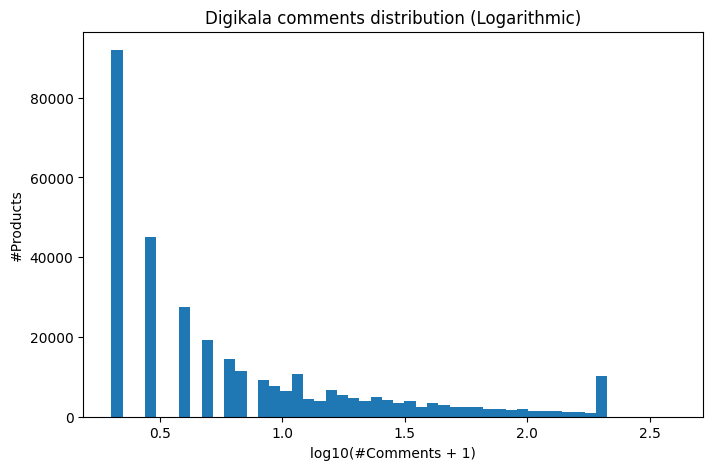

In [ ]:
log_counts = np.log10(cnt_df["comment_cnt"] + 1)

plt.figure(figsize=(8, 5))
plt.hist(log_counts, bins=50)
plt.xlabel("log10(#Comments + 1)")
plt.ylabel("#Products")
plt.title("Digikala comments distribution (Logarithmic)")
plt.show()

C:\Users\sinab\AppData\Local\Temp\ipykernel_11768\4167927050.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bucket")


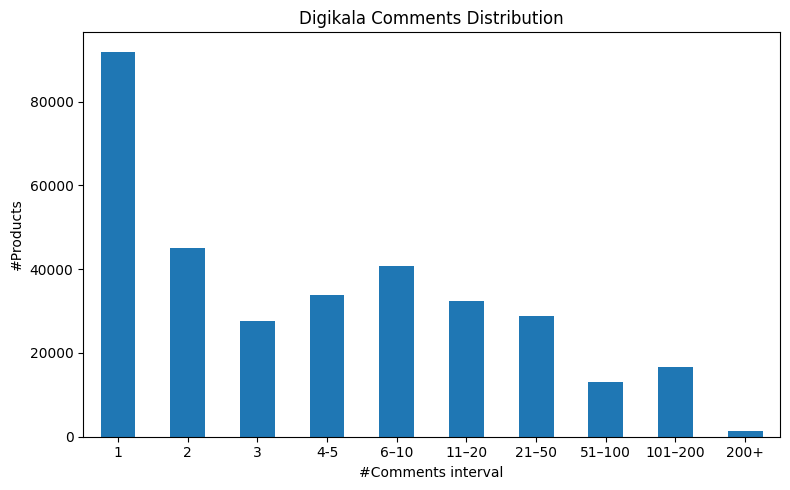

In [ ]:
bins   = [0, 1, 2, 3, 5, 10, 20, 50, 100, 200, np.inf]
labels = ['1', '2', '3', '4-5', '6–10', '11–20', '21–50', '51–100', '101–200', '200+']

bucketed = (
    comment_counts
    .to_frame(name="cnt")
    .assign(bucket=pd.cut(comment_counts, bins=bins, labels=labels, right=True))
)

bucket_counts = (
    bucketed
    .groupby("bucket")
    .size()
    .reindex(labels, fill_value=0)
)

plt.figure(figsize=(8, 5))
bucket_counts.plot(kind="bar")
plt.xlabel("#Comments interval")
plt.ylabel("#Products")
plt.title("Digikala Comments Distribution")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
df = pd.read_csv(
    COMMENTS_PATH,
    usecols=["rate"],
    dtype={"rate": "float32"},
    low_memory=False
)

In [ ]:
df["rate_num"] = pd.to_numeric(df["rate"], errors="coerce")

labels = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', 'Invalid']
bins   = [-0.1, 0.1, 1.1, 2.1, 3.1, 4.1, 5.1, np.inf]

df["bucket"] = pd.cut(
    df["rate_num"].fillna(np.inf),
    bins=bins,
    labels=labels,
    right=False
)

bucket_counts = (
    df.groupby("bucket")
    .size()
    .reindex(labels, fill_value=0)
)

print(bucket_counts)

bucket
0.0         529195
1.0         332792
2.0         219159
3.0         994416
4.0        1595541
5.0        2485185
Invalid          1
dtype: int64


C:\Users\sinab\AppData\Local\Temp\ipykernel_11768\1564401196.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("bucket")


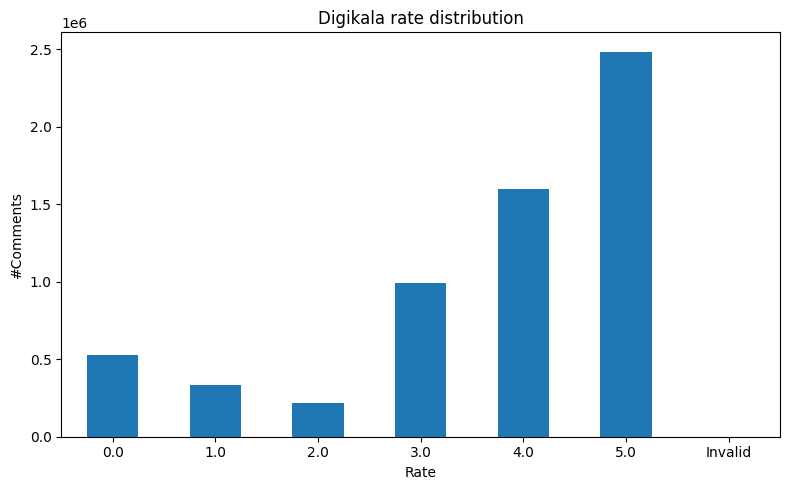

In [ ]:
plt.figure(figsize=(8, 5))
bucket_counts.plot(kind="bar")
plt.xlabel("Rate")
plt.ylabel("#Comments")
plt.title("Digikala rate distribution")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Summarize a subset of raw products file

In [ ]:
COMMENTS_FILE = "subset_comments.csv"
PRODUCT_FILE  = "subset_product.csv"
FULL_COMMENTS_FILE = "digikala-comments.csv"
FULL_PRODUCT_FILE  = "digikala-products.csv"
#OUTPUT_EXCEL  = "product_summaries.xlsx"
OUTPUT_CSV = "product_summaries.csv"

In [ ]:
MAX_COMMENTS      = 400
MAX_SUM_SENTENCES = 30
MIN_SENT_LEN_WORD = 5

normalizer = Normalizer()

In [ ]:
def smart_read(path):
    ext = os.path.splitext(path)[1].lower()
    return pd.read_csv(path) if ext in (".csv", ".txt") else pd.read_excel(path)

def clean_text(txt):
    if pd.isna(txt): return ""
    txt = normalizer.normalize(str(txt))
    txt = re.sub(r'https?://\S+|\u200c', ' ', txt)
    return re.sub(r'\s+', ' ', txt).strip()

# First summarizer (Useless)
def tfidf_summary(text):
    if not text:
        return "---"

    if len(text.split()) < 30:
        return text.strip()

    sentences = [s.strip() for s in sent_tokenize(text)]
    sentences = [s for s in sentences if len(s.split()) >= MIN_SENT_LEN_WORD]

    if len(sentences) <= MAX_SUM_SENTENCES:
        return " ".join(sentences)

    vect = TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1,2))
    tfidf = vect.fit_transform(sentences)
    scores = (tfidf.sum(axis=1) / (tfidf != 0).sum(axis=1)).A1
    top_idx = np.argsort(scores)[-MAX_SUM_SENTENCES:][::-1]
    selected = [sentences[i] for i in sorted(top_idx)]
    return " ".join(selected)

def list_snip(lst, k=4):
    return "؛ ".join([x for x in lst if x and len(x) > 5][:k]) or "---"

In [ ]:
def tfidf_comment_summary(bodies, max_comments=400, top_k=30):
    snippets = bodies[:max_comments]

    #docs = [c for c in snippets if len(c.split()) >= 3]

    docs = [c for c in snippets]
    if not docs:
        return "---"
    if len(docs) <= top_k:
        return "\n".join(f"نظر {i+1}: {doc}" for i, doc in enumerate(docs))

    try:
        vect = TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1,2))
        X    = vect.fit_transform(docs)
        scores = (X.sum(axis=1) / (X != 0).sum(axis=1)).A1
        top_idx = np.argsort(scores)[-top_k:][::-1]
        selected = [docs[i] for i in top_idx]
    except ValueError:
        selected = docs[:top_k]

    return "\n".join(f"نظر {j+1}: {s}" for j, s in enumerate(selected))

In [ ]:
if not os.path.exists(COMMENTS_FILE) or not os.path.exists(PRODUCT_FILE):
    print("Subset files not found — creating 1/5 random sample ...")

    full_comments = pd.read_csv(FULL_COMMENTS_FILE)
    full_products = pd.read_csv(FULL_PRODUCT_FILE, low_memory=False)

    sampled_products = full_products.sample(frac=0.2, random_state=42)
    sampled_comments = full_comments[full_comments['product_id'].isin(sampled_products['id'])]

    sampled_comments.to_csv(COMMENTS_FILE, index=False)
    sampled_products.to_csv(PRODUCT_FILE, index=False)

    print(f"Saved {len(sampled_comments)} comments and {len(sampled_products)} products to subset files.")

In [ ]:
print("Reading data ...")
df_cmnt = smart_read(COMMENTS_FILE)
df_prod = smart_read(PRODUCT_FILE)

Reading data ...


In [ ]:
if "body" in df_cmnt.columns:
    df_cmnt["body_norm"] = df_cmnt["body"].apply(clean_text)
if "advantages" in df_cmnt.columns:
    df_cmnt["advantages_norm"] = df_cmnt["advantages"].apply(clean_text)
if "disadvantages" in df_cmnt.columns:
    df_cmnt["disadvantages_norm"] = df_cmnt["disadvantages"].apply(clean_text)
if "title" in df_cmnt.columns:
    df_cmnt["title_norm"] = df_cmnt["title"].apply(clean_text)

df_cmnt["product_id"] = df_cmnt["product_id"].astype(str)
df_prod["product_id"] = df_prod["id"].astype(str)

In [ ]:
print("Aggregating comments ...")
agg_map = {
    "rate": ["mean", "count"],
    "likes": "sum",
    "dislikes": "sum",
    "body_norm": lambda x: list(x),
    "advantages_norm": lambda x: list(x),
    "disadvantages_norm": lambda x: list(x),
}
g = df_cmnt.groupby("product_id").agg(agg_map)
g.columns = ["rate_mean", "rate_cnt", "likes", "dislikes",
             "bodies", "pros", "cons"]
g = g.reset_index()

merged = df_prod.merge(g, on="product_id", how="left")

Aggregating comments ...


In [ ]:
print("Generating summaries ...")
rows = []
for _, row in tqdm(merged.iterrows(), total=len(merged)):
    pid = row["product_id"]

    specs = (
        f"Title: {row.get('title_fa', '---')} | "
        f"Brand: {row.get('Brand', '---')} | "
        f"Category: {row.get('Category1', '---')}>{row.get('Category2', '---')} | "
        f"Price: {row.get('Price', '---'):,} | "
        f"Lowest price last month: {row.get('min_price_last_month', '---'):,}"
    )

    stats = (
        f"Average rating {row.rate_mean:.2f} from {int(row.rate_cnt)} votes"
        if not pd.isna(row.rate_mean) else "---"
    )

    pros = list_snip(row.pros if isinstance(row.pros, list) else [])
    cons = list_snip(row.cons if isinstance(row.cons, list) else [])


    bodies = row.bodies if isinstance(row.bodies, list) else []
    joined = " ".join(bodies[:MAX_COMMENTS])
    summary_text = tfidf_summary(joined)


    rows.append(
        {
            "product_id"          : pid,
            "title_fa"            : row.get("title_fa", "---"),
            "brand"               : row.get("Brand", "---"),
            "category1"           : row.get("Category1", "---"),
            "category2"           : row.get("Category2", "---"),
            "price"               : row.get("Price", np.nan),
            "min_price_last_month": row.get("min_price_last_month", np.nan),
            "rate_mean"           : row.rate_mean,
            "rate_cnt"            : row.rate_cnt,
            "likes"               : row.likes,
            "dislikes"            : row.dislikes,
            "pros_sample"         : pros,
            "cons_sample"         : cons,
            "comments_summary"    : summary_text,
            "summary_full"        : (
                f"Product ID: {pid}\n"
                f"{specs}\n"
                f"{stats}\n"
                f"+ Pros: {pros}\n"
                f"- Cons: {cons}\n"
                f"Extractive summary: {summary_text}"
            ),
        }
    )

In [ ]:
df_out = pd.DataFrame(rows)
column_order = [
    "product_id",
    "title_fa", "brand", "category1", "category2",
    "price", "min_price_last_month",
    "rate_mean", "rate_cnt", "likes", "dislikes",
    "pros_sample", "cons_sample", "comments_summary",
    "summary_full"
]

In [ ]:
df_out[column_order].to_csv(OUTPUT_CSV, index=False)
print(f"File '{OUTPUT_CSV}' has been created with {len(df_out)} rows.")

File 'product_summaries.csv' has been created with 256699 rows.


In [ ]:
df = pd.read_csv("product_summaries.csv")

In [ ]:
df["word_count"] = df["comments_summary"].str.split().apply(len)
df["sent_count"] = df["comments_summary"].str.count(r"[.؟!?]") + 1

In [ ]:
print("Word Count Statistics:")
print(df["word_count"].describe(), "\n")
print("Sentence Count Statistics:")
print(df["sent_count"].describe(), "\n")

print("Word Count Percentiles:")
print(df["word_count"].quantile([0.25, 0.5, 0.75, 0.9, 0.99]))

Word Count Statistics:
count    256699.000000
mean         19.333242
std          43.950486
min           1.000000
25%           1.000000
50%           1.000000
75%          16.000000
max         841.000000
Name: word_count, dtype: float64 

Sentence Count Statistics:
count    256699.000000
mean          1.641685
std           1.545783
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          36.000000
Name: sent_count, dtype: float64 

Word Count Percentiles:
0.25      1.0
0.50      1.0
0.75     16.0
0.90     61.0
0.99    214.0
Name: word_count, dtype: float64


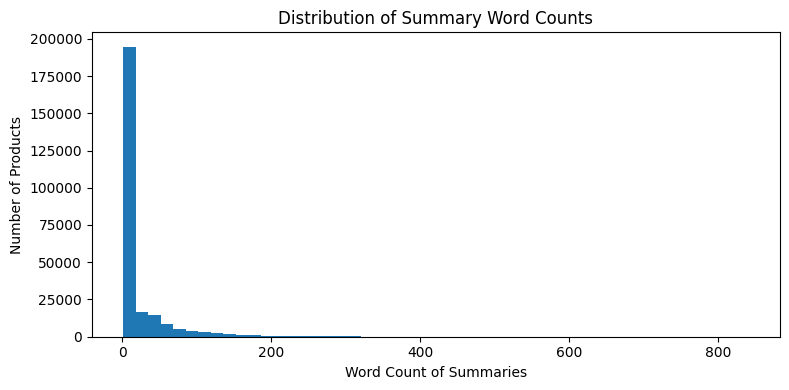

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(df["word_count"], bins=50)
plt.xlabel("Word Count of Summaries")
plt.ylabel("Number of Products")
plt.title("Distribution of Summary Word Counts")
plt.tight_layout()
plt.show()

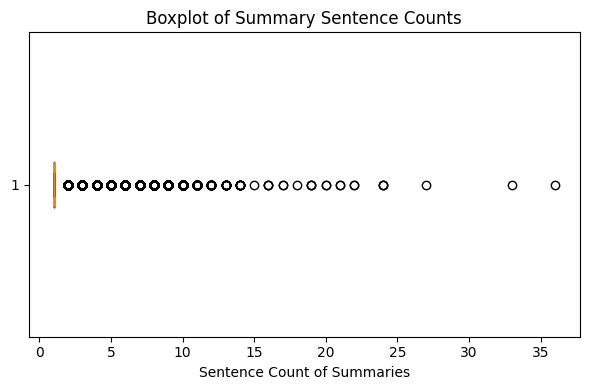

In [ ]:
plt.figure(figsize=(6, 4))
plt.boxplot(df["sent_count"], vert=False)
plt.xlabel("Sentence Count of Summaries")
plt.title("Boxplot of Summary Sentence Counts")
plt.tight_layout()
plt.show()

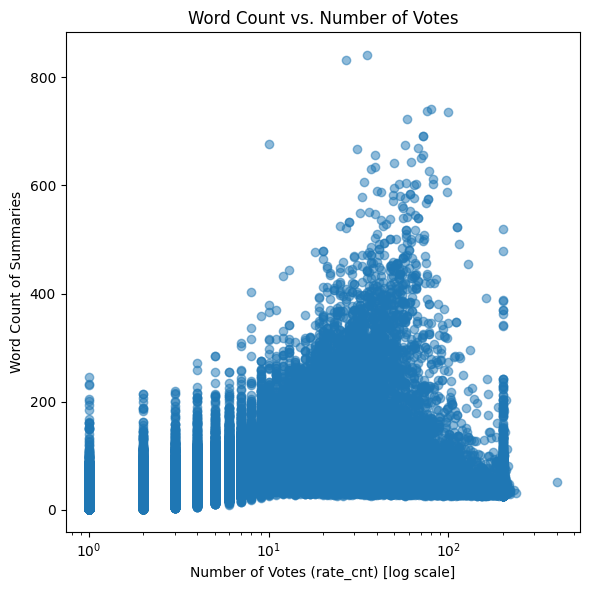

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(df["rate_cnt"], df["word_count"], alpha=0.5)
plt.xscale("log")
plt.xlabel("Number of Votes (rate_cnt) [log scale]")
plt.ylabel("Word Count of Summaries")
plt.title("Word Count vs. Number of Votes")
plt.tight_layout()
plt.show()

In [ ]:
empty_frac = (df["comments_summary"].str.strip() == "---").mean()
print(f"Fraction of products with empty summaries (\"---\"): {empty_frac:.2%}")

Fraction of products with empty summaries ("---"): 64.32%


In [ ]:
pros_missing = (df["pros_sample"] == "---").mean()
cons_missing = (df["cons_sample"] == "---").mean()
print(f"Fraction missing pros_sample: {pros_missing:.2%}")
print(f"Fraction missing cons_sample: {cons_missing:.2%}")

Fraction missing pros_sample: 83.42%
Fraction missing cons_sample: 86.93%


In [ ]:
df.to_csv("product_summaries_with_stats.csv", index=False)

In [ ]:
df.head()

,product_id,title_fa,brand,category1,category2,price,min_price_last_month,rate_mean,rate_cnt,likes,dislikes,pros_sample,cons_sample,comments_summary,summary_full,word_count,sent_count
0,11728451,صندل مردانه پویان گام پیام مدل داریوش کد 10645,پویان گام پیام,کفش مردانه,صندل مردانه,2711000,0,NaN,NaN,NaN,NaN,---,---,---,Product ID: 11728451\nTitle: صندل مردانه پویان...,1,1
1,3768650,دستبند زنانه ناکسیگو طرح مریم کد BR4071,ناکسیگو,اکسسوری زنانه,زیورآلات زنانه,470000,0,3.142857,14.0,1.0,0.0,"['نوشتن اسم روی دستبند', 'طرح خوب ']؛ ['زیبایی']",---,واسه کادو دادن چیز قشنگیه عالیه ممنون از شما ح...,Product ID: 3768650\nTitle: دستبند زنانه ناکسی...,130,3
2,231776,کتاب زندگانی حضرت علی اثر جواد فاضل,انتشارات دنیای کتاب,کتاب دینی,NaN,430000,0,2.400000,5.0,0.0,0.0,"['چاپ و صحافی عالی \ r', 'کتاب کمیاب \ r', 'قی...",---,کتابی است که به شرح زندگانی حضرت علی (ع) می پر...,Product ID: 231776\nTitle: کتاب زندگانی حضرت ع...,123,5
3,5157570,گردنبند طلا 18 عیار زنانه کرابو طرح ماهی مدل K...,کرابو,زیورآلات طلا زنانه,گردنبند طلا زنانه,45059300,0,NaN,NaN,NaN,NaN,---,---,---,Product ID: 5157570\nTitle: گردنبند طلا 18 عیا...,1,1
4,9448547,تی شرت آستین بلند زنانه مدل کامیک,متفرقه,لباس زنانه,تی شرت زنانه,2550000,0,NaN,NaN,NaN,NaN,---,---,---,Product ID: 9448547\nTitle: تی شرت آستین بلند ...,1,1


In [ ]:
COMMENTS_PATH = "subset_comments.csv"
PRODUCT_PATH  = "subset_product.csv"

df_comments = pd.read_csv(COMMENTS_PATH, usecols=["product_id"])
df_products = pd.read_csv(PRODUCT_PATH)

In [ ]:
comment_counts = (
    df_comments
    .groupby("product_id")
    .size()
    .rename("comment_cnt")
    .reset_index()
)

df_products = df_products.rename(columns={"id": "product_id"})
df_merged = df_products.merge(comment_counts, on="product_id", how="left")
df_merged["comment_cnt"] = df_merged["comment_cnt"].fillna(0).astype(int)

In [ ]:
total_products = len(df_products)
zero_products  = df_merged[df_merged["comment_cnt"] == 0]
print(f"Total products in subset: {total_products}")
print(f"Products with zero comments: {len(zero_products)}")

Total products in subset: 256699
Products with zero comments: 165092


In [ ]:
zero_products.head(10)

,product_id,title_fa,Rate,Rate_cnt,Category1,Category2,Brand,Price,Seller,Is_Fake,min_price_last_month,sub_category,comment_cnt
0,11728451,صندل مردانه پویان گام پیام مدل داریوش کد 10645,100,1,کفش مردانه,صندل مردانه,پویان گام پیام,2711000,دیجی‌کالا,False,0,clothe,0
3,5157570,گردنبند طلا 18 عیار زنانه کرابو طرح ماهی مدل K...,0,0,زیورآلات طلا زنانه,گردنبند طلا زنانه,کرابو,45059300,کرابو,False,0,clothe,0
4,9448547,تی شرت آستین بلند زنانه مدل کامیک,0,0,لباس زنانه,تی شرت زنانه,متفرقه,2550000,پیلاپیلا,False,0,clothe,0
6,10281415,جاکلیدی گالری باجو طرح سردار شهید حاج قاسم سلی...,0,0,اکسسوری زنانه و مردانه,زیورآلات زنانه و مردانه,متفرقه,1690000,گالری باجو,False,0,clothe,0
10,9151996,کتاب More Rules for Life اثر Kitty Flanagan ان...,0,0,کتاب چاپی غیر فارسی,NaN,متفرقه,1820000,بوکم,False,0,book & stationary & art,0
11,11109032,کتاب از بلوغ تا یائسگی اثر عزیزه اسدی انتشارا...,0,0,کتاب علوم کاربردی، تکنولوژی و مهندسی,NaN,انتشارات ارسطو,1980000,کتابار,False,0,book & stationary & art,0
12,8208985,کتاب جشن تولد مامان اثر جاناکی سوریاراچچی انتش...,100,1,کتاب کودک و نوجوان,NaN,انتشارات آسمان علم,165000,ارغوان پاییز,False,0,book & stationary & art,0
16,10233406,عینک آفتابی مدل P3967gr,0,0,اکسسوری زنانه و مردانه,عینک زنانه و مردانه,متفرقه,4200000,عینک دونی,False,0,clothe,0
20,1420008,دستبند طلا 18 عیار مدل z1069,0,0,زیورآلات طلا زنانه,دستبند طلا زنانه,متفرقه,11532100,نارگلد گالری,False,0,clothe,0
24,9273131,نیم تنه زنانه مدل POWER GIRL کد E25 رنگ سفید,0,0,لباس زنانه,تاپ و نیم تنه زنانه,متفرقه,990000,بامینو,False,0,clothe,0


In [ ]:
dist = (
    zero_products["Category1"]
    .value_counts()
    .rename_axis("Category1")
    .reset_index(name="count")
)
dist.head(10)

,Category1,count
0,لباس زنانه,13058
1,اکسسوری زنانه و مردانه,12959
2,اسباب بازی,9815
3,اکسسوری زنانه,9771
4,لباس مردانه,8692
5,زیورآلات طلا زنانه,8210
6,کتاب چاپی غیر فارسی,7045
7,اکسسوری مردانه,6903
8,دفتر و کاغذ و مقوا,6371
9,دخترانه,6225


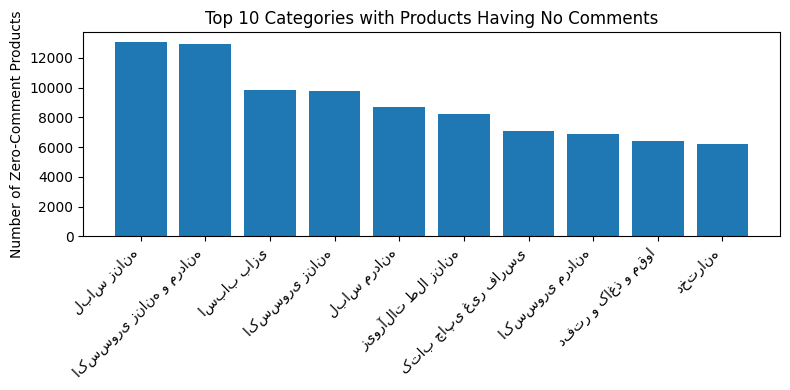

In [ ]:
plt.figure(figsize=(8,4))
plt.bar(dist["Category1"].head(10), dist["count"].head(10))
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Zero-Comment Products")
plt.title("Top 10 Categories with Products Having No Comments")
plt.tight_layout()
plt.show()

In [ ]:
COMMENTS_PATH = "digikala-comments.csv"
PRODUCT_PATH  = "digikala-products.csv"

df_comments = pd.read_csv(COMMENTS_PATH, usecols=["product_id"])
df_products = pd.read_csv(PRODUCT_PATH)

C:\Users\sinab\AppData\Local\Temp\ipykernel_11768\3743096459.py:5: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_products = pd.read_csv(PRODUCT_PATH)


In [ ]:
comment_counts = (
    df_comments
    .groupby("product_id")
    .size()
    .rename("comment_cnt")
    .reset_index()
)

df_products = df_products.rename(columns={"id": "product_id"})
df_merged = df_products.merge(comment_counts, on="product_id", how="left")
df_merged["comment_cnt"] = df_merged["comment_cnt"].fillna(0).astype(int)

In [ ]:
total_products = len(df_products)
zero_products  = df_merged[df_merged["comment_cnt"] == 0]
print(f"Total products in subset: {total_products}")
print(f"Products with zero comments: {len(zero_products)}")

Total products in subset: 1283496
Products with zero comments: 828527


In [ ]:
zero_products.head(10)

,product_id,title_fa,Rate,Rate_cnt,Category1,Category2,Brand,Price,Seller,Is_Fake,min_price_last_month,sub_category,comment_cnt
7,7096768,آبسلانگ مدل s10 بسته 500 عددی,100,2,آبسلانگ,NaN,متفرقه,1872000,سلامت ساز راد,False,0,beauty,0
28,7611799,آبسلانگ مدل T1 بسته 35 عددی,40,1,آبسلانگ,NaN,متفرقه,450000,پخش پرواز,False,0,beauty,0
31,12324978,مداد ابرو آرکانسیل مدل ideal sourcils شماره 320,0,0,آرایش ابرو,مداد ابرو,آرکانسیل,3500000,پیشتاز سلامت,False,0,beauty,0
32,11542467,ژل ابرو شگلم مدل Set Me Up به همراه برس ابرو,100,3,آرایش ابرو,ژل و صابون ابرو,شگلم,3690000,بیانکا بوتیک,False,4850000,beauty,0
33,11544054,ژل ابرو شگلم مدل Set Me Up,90,4,آرایش ابرو,ژل و صابون ابرو,شگلم,3880000,بیانکا بوتیک,False,0,beauty,0
34,4696126,صابون لیفت ابرو رولوشن مدل Styler,74,51,آرایش ابرو,ژل و صابون ابرو,رولوشن,3890000,بیانکا بوتیک,False,0,beauty,0
35,12449463,مداد ابرو شگلم مدل Fill Me In - Taupe,0,0,آرایش ابرو,مداد ابرو,شگلم,3950000,بیانکا بوتیک,False,0,beauty,0
36,11630408,کیت سایه ابرو وت اند وایلد مدل ultimatebrow شم...,0,0,آرایش ابرو,سایه ابرو,وت ان وایلد,3800000,بیوتی کده شاپ,False,0,beauty,0
37,6165195,کرم تقویت کننده ابرو سریتا مدل SEH حجم 20 میلی...,82,26,آرایش ابرو,تقویت‌کننده ابرو,سریتا,3990000,یانگوم,False,0,beauty,0
38,4018141,کیت سایه ابرو میلانی مدل Brow Fix شماره 03,86,3,آرایش ابرو,سایه ابرو,میلانی,3990000,فروشگاه انصاری بازار,False,0,beauty,0


In [ ]:
dist = (
    zero_products["Category1"]
    .value_counts()
    .rename_axis("Category1")
    .reset_index(name="count")
)
dist.head(10)

,Category1,count
0,اکسسوری زنانه و مردانه,65381
1,لباس زنانه,65101
2,اسباب بازی,49597
3,اکسسوری زنانه,49403
4,لباس مردانه,43585
5,زیورآلات طلا زنانه,41098
6,کتاب چاپی غیر فارسی,35497
7,اکسسوری مردانه,34629
8,دفتر و کاغذ و مقوا,32201
9,دخترانه,31266


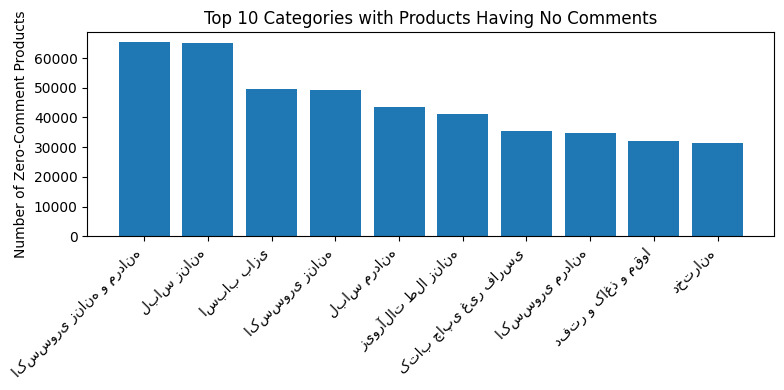

In [ ]:
plt.figure(figsize=(8,4))
plt.bar(dist["Category1"].head(10), dist["count"].head(10))
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Zero-Comment Products")
plt.title("Top 10 Categories with Products Having No Comments")
plt.tight_layout()
plt.show()

We found out that there are many rows in products file which don't have any comments in comments file, so we should delete them from products file and do summarization on products with non-zero comments.

# Drop products with zero comments

In [ ]:
PRODUCTS_FULL = "digikala-products.csv"
COMMENTS_FULL = "digikala-comments.csv"

df_comments = pd.read_csv(COMMENTS_FULL, usecols=["product_id"], low_memory=False)

comment_counts = (
    df_comments
    .groupby("product_id")
    .size()
    .rename("comment_cnt")
    .reset_index()
)

In [ ]:
df_products = pd.read_csv(PRODUCTS_FULL, low_memory=False)

df_products = df_products.rename(columns={"id": "product_id"})

df_merged = df_products.merge(comment_counts, on="product_id", how="left")
df_merged["comment_cnt"] = df_merged["comment_cnt"].fillna(0).astype(int)

df_cleaned = df_merged[df_merged["comment_cnt"] > 0].copy()

In [ ]:
df_cleaned = df_cleaned.drop(columns=["comment_cnt"])
df_cleaned.to_csv("cleaned-products.csv", index=False)
print(f"Created 'cleaned-products.csv' with {len(df_cleaned)} products (non-zero comments).")

Created 'cleaned-products.csv' with 454969 products (non-zero comments).


In [ ]:
COMMENTS_PATH = "digikala-comments.csv"
PRODUCT_PATH  = "cleaned-products.csv"

df_comments = pd.read_csv(COMMENTS_PATH, usecols=["product_id"])
df_products = pd.read_csv(PRODUCT_PATH)

comment_counts = (
    df_comments
    .groupby("product_id")
    .size()
    .rename("comment_cnt")
    .reset_index()
)

df_products = df_products.rename(columns={"id": "product_id"})
df_merged = df_products.merge(comment_counts, on="product_id", how="left")
df_merged["comment_cnt"] = df_merged["comment_cnt"].fillna(0).astype(int)

total_products = len(df_products)
zero_products  = df_merged[df_merged["comment_cnt"] == 0]
print(f"Total products in main data: {total_products}")
print(f"Products with zero comments: {len(zero_products)}")

Total products in subset: 454969
Products with zero comments: 0


**Drop products with <4 comments (Testing)**

In [ ]:
COMMENTS_PATH = "digikala-comments.csv"
PRODUCT_PATH  = "cleaned-products.csv"

df_comments = pd.read_csv(COMMENTS_PATH, usecols=["product_id"])
df_products = pd.read_csv(PRODUCT_PATH)

comment_counts = (
    df_comments
    .groupby("product_id")
    .size()
    .rename("comment_cnt")
    .reset_index()
)

df_products = df_products.rename(columns={"id": "product_id"})
df_merged = df_products.merge(comment_counts, on="product_id", how="left")
df_merged["comment_cnt"] = df_merged["comment_cnt"].fillna(0).astype(int)

df_filtered = df_merged[df_merged["comment_cnt"] >= 4].copy()

print(f"Total products before filtering : {len(df_products)}")
print(f"Total products with ≥4 comments: {len(df_filtered)}")

df_filtered.to_csv("products_min4_comments.csv", index=False)

Total products before filtering : 454969
Total products with ≥4 comments: 231515


# Summarize a subset of cleaned products (Non-zero comments)

In [ ]:
FULL_COMMENTS       = "digikala-comments.csv"
CLEAN_PRODUCTS      = "cleaned-products.csv"
SUBSET_COMMENTS     = "cleaned_subset_comments.csv"
SUBSET_PRODUCTS     = "cleaned_subset_product.csv"
OUTPUT_CSV          = "cleaned_product_summaries.csv"
OUTPUT_EXCEL        = "cleaned_product_summaries.xlsx"

In [ ]:
MAX_COMMENTS        = 400
MAX_SUM_SENTENCES   = 5
MIN_SENT_LEN_WORD   = 5

normalizer = Normalizer()

In [ ]:
if not os.path.exists(SUBSET_PRODUCTS) or not os.path.exists(SUBSET_COMMENTS):
    df_prod = pd.read_csv(CLEAN_PRODUCTS, low_memory=False)
    sampled_prod = df_prod.sample(frac=0.2, random_state=42)
    sampled_ids  = sampled_prod["product_id"].astype(str)

    df_comm = pd.read_csv(FULL_COMMENTS, low_memory=False)
    df_comm = df_comm[df_comm["product_id"].astype(str).isin(sampled_ids)]

    sampled_prod.to_csv(SUBSET_PRODUCTS, index=False)
    df_comm.to_csv(SUBSET_COMMENTS, index=False)
    print(f"Built subset: {len(sampled_prod)} products, {len(df_comm)} comments")
else:
    print("Subset files already exist, skipping build.")

Subset files already exist, skipping build.


In [ ]:
print("Reading subset and normalizing text…")
df_cmnt = pd.read_csv(SUBSET_COMMENTS, low_memory=False)
df_prod = pd.read_csv(SUBSET_PRODUCTS, low_memory=False)

for col in ["body","advantages","disadvantages","title"]:
    norm_col = f"{col}_norm"
    if col in df_cmnt:
        df_cmnt[norm_col] = df_cmnt[col].apply(clean_text)

df_cmnt["product_id"] = df_cmnt["product_id"].astype(str)
df_prod["product_id"] = df_prod["product_id"].astype(str)

Reading subset and normalizing text…


In [ ]:
print("Generating cleaned summaries…")
rows = []
for _, row in tqdm(merged.iterrows(), total=len(merged)):
    pid   = row["product_id"]
    pros  = list_snip(row.pros if isinstance(row.pros,list) else [])
    cons  = list_snip(row.cons if isinstance(row.cons,list) else [])

    '''
    bodies = row.bodies if isinstance(row.bodies, list) else []
    joined = " ".join(bodies[:MAX_COMMENTS])
    summary_text = tfidf_summary(joined)
    '''

    bodies = row.bodies if isinstance(row.bodies, list) else []
    '''
    summary_text = tfidf_numbered_summary(
        bodies,
        max_comments=MAX_COMMENTS,
        max_sentences=MAX_SUM_SENTENCES,
        min_sent_len=MIN_SENT_LEN_WORD
    )
    '''

    summary_text = tfidf_comment_summary(
        bodies,
        max_comments=MAX_COMMENTS,
        top_k=MAX_SUM_SENTENCES
    )

    rows.append({
        "product_id": pid,
        "title_fa"  : row.get("title_fa","---"),
        "brand"     : row.get("Brand","---"),
        "category1" : row.get("Category1","---"),
        "category2" : row.get("Category2","---"),
        "price"     : row.get("Price", np.nan),
        "min_price_last_month": row.get("min_price_last_month", np.nan),
        "rate_mean" : row.rate_mean,
        "rate_cnt"  : row.rate_cnt,
        "likes"     : row.likes,
        "dislikes"  : row.dislikes,
        "pros_sample": pros,
        "cons_sample": cons,
        "comments_summary": summary_text
    })

Generating cleaned summaries…


  0%|                                                                                        | 0/90994 [00:00<?, ?it/s]C:\Users\sinab\AppData\Local\Temp\ipykernel_3528\1968582472.py:15: RuntimeWarning: invalid value encountered in divide
  scores = (X.sum(axis=1) / (X != 0).sum(axis=1)).A1
100%|███████████████████████████████████████████████████████████████████████████| 90994/90994 [01:48<00:00, 838.04it/s]


In [ ]:
print("Aggregating comments…")
agg_map = {
    "rate": ["mean","count"],
    "likes": "sum",
    "dislikes": "sum",
    "body_norm": lambda x: list(x),
    "advantages_norm": lambda x: list(x),
    "disadvantages_norm": lambda x: list(x),
}
g = df_cmnt.groupby("product_id").agg(agg_map)
g.columns = ["rate_mean","rate_cnt","likes","dislikes","bodies","pros","cons"]
g = g.reset_index()

merged = df_prod.merge(g, on="product_id", how="left")

Aggregating comments…


In [ ]:
df_out = pd.DataFrame(rows)
cols = [
    "product_id","title_fa","brand","category1","category2",
    "price","min_price_last_month","rate_mean","rate_cnt",
    "likes","dislikes","pros_sample","cons_sample","comments_summary"
]

In [ ]:
df_out[cols].to_csv(OUTPUT_CSV, index=False)
print(f"Saved CSV → {OUTPUT_CSV} ({len(df_out)} rows)")

Saved CSV → cleaned_product_summaries.csv (90994 rows)


In [ ]:
df_out[cols].to_excel(OUTPUT_EXCEL, index=False)
print(f"Saved Excel → {OUTPUT_EXCEL}")

Saved Excel → cleaned_product_summaries.xlsx


In [ ]:
df = pd.read_csv("cleaned_product_summaries.csv")

df["word_count"] = df["comments_summary"].str.split().apply(len)
df["sent_count"] = df["comments_summary"].str.count(r"[.؟!?]") + 1

In [ ]:
print("Word Count Statistics:")
print(df["word_count"].describe(), "\n")
print("Sentence Count Statistics:")
print(df["sent_count"].describe(), "\n")

print("Word Count Percentiles:")
print(df["word_count"].quantile([0.25, 0.5, 0.75, 0.9, 0.99]))

Word Count Statistics:
count    90994.000000
mean        88.462492
std        100.525671
min          2.000000
25%         15.000000
50%         47.000000
75%        133.000000
max       1620.000000
Name: word_count, dtype: float64 

Sentence Count Statistics:
count    90994.000000
mean         2.924797
std          3.211265
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         75.000000
Name: sent_count, dtype: float64 

Word Count Percentiles:
0.25     15.0
0.50     47.0
0.75    133.0
0.90    224.0
0.99    434.0
Name: word_count, dtype: float64


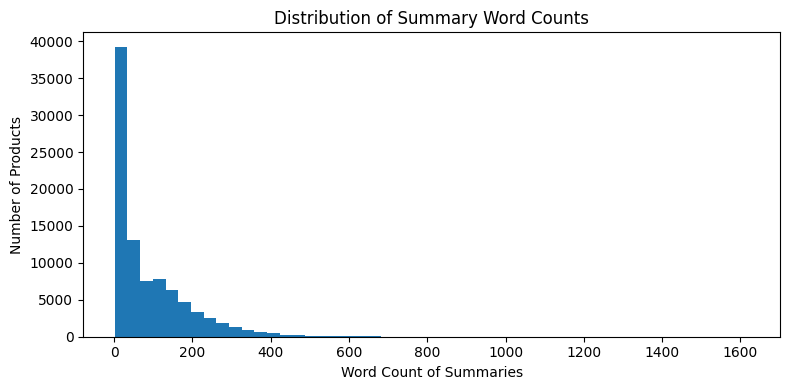

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(df["word_count"], bins=50)
plt.xlabel("Word Count of Summaries")
plt.ylabel("Number of Products")
plt.title("Distribution of Summary Word Counts")
plt.tight_layout()
plt.show()

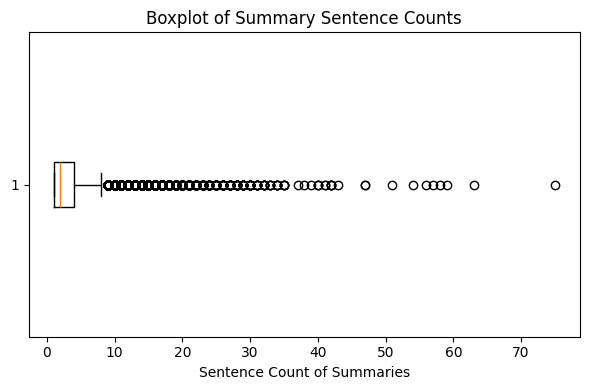

In [ ]:
plt.figure(figsize=(6, 4))
plt.boxplot(df["sent_count"], vert=False)
plt.xlabel("Sentence Count of Summaries")
plt.title("Boxplot of Summary Sentence Counts")
plt.tight_layout()
plt.show()

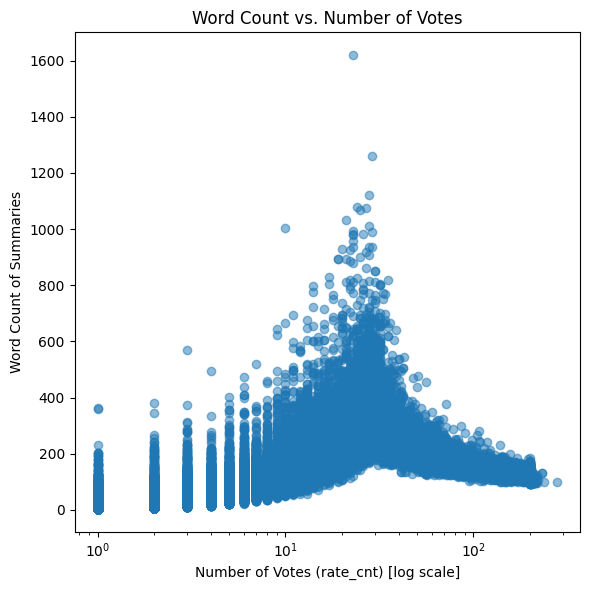

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(df["rate_cnt"], df["word_count"], alpha=0.5)
plt.xscale("log")
plt.xlabel("Number of Votes (rate_cnt) [log scale]")
plt.ylabel("Word Count of Summaries")
plt.title("Word Count vs. Number of Votes")
plt.tight_layout()
plt.show()

In [ ]:
empty_frac = (df["comments_summary"].str.strip() == "---").mean()
print(f"Fraction of products with empty summaries (\"---\"): {empty_frac:.2%}")

Fraction of products with empty summaries ("---"): 0.00%


In [ ]:
pros_missing = (df["pros_sample"] == "---").mean()
cons_missing = (df["cons_sample"] == "---").mean()
print(f"Fraction missing pros_sample: {pros_missing:.2%}")
print(f"Fraction missing cons_sample: {cons_missing:.2%}")

Fraction missing pros_sample: 53.62%
Fraction missing cons_sample: 63.27%


In [ ]:
print("rate_cnt statistics:")
print(df["rate_cnt"].describe(), "\n")

rate_cnt statistics:
count    90994.000000
mean        19.890663
std         43.101556
min          1.000000
25%          1.000000
50%          4.000000
75%         13.000000
max        279.000000
Name: rate_cnt, dtype: float64 



In [ ]:
print("rate_cnt percentiles:")
print(df["rate_cnt"].quantile([0.25, 0.5, 0.75, 0.9, 0.99]))

rate_cnt percentiles:
0.25      1.0
0.50      4.0
0.75     13.0
0.90     52.0
0.99    200.0
Name: rate_cnt, dtype: float64


In [ ]:
total = len(df)
zero_votes = (df["rate_cnt"] == 0).mean()
one_to_three = ((df["rate_cnt"] >= 1) & (df["rate_cnt"] <= 3)).mean()
four_to_five = ((df["rate_cnt"] >= 4) & (df["rate_cnt"] <= 5)).mean()
six_to_ten = ((df["rate_cnt"] >= 6) & (df["rate_cnt"] <= 10)).mean()

print(f"Fraction with zero votes: {zero_votes:.2%}")
print(f"Fraction with 1–3 votes: {one_to_three:.2%}")
print(f"Fraction with 4–5 votes: {four_to_five:.2%}")
print(f"Fraction with 6–10 votes: {six_to_ten:.2%}")

Fraction with zero votes: 0.00%
Fraction with 1–3 votes: 49.47%
Fraction with 4–5 votes: 9.66%
Fraction with 6–10 votes: 12.04%


# Summary data cleaning

**pros_sample and cons_sample cleaning**

In [ ]:
def clean_pros_cons(input_csv: str,
                    output_csv: str,
                    output_excel: str) -> pd.DataFrame:
    df = pd.read_csv(input_csv)
    REMOVE_SINGLE = {"نداره", "ندارد", "هیچی" , "نمیدونم", "ندیدم", "عالی", "هیچ", "خوب"}

    def _clean(cell: str) -> str:
        if pd.isna(cell) or cell.strip() == "---":
            return "---"
        text = cell

        text = re.sub(r"[\\\/]\s*r", " ", text)
        text = text.replace("\\r", " ").replace("\r", " ")
        text = text.strip()

        parts = re.split(r"\]\s*[؛;]\s*", text)
        items = []
        for part in parts:
            part = part.strip()
            if not part.startswith("["): part = "[" + part
            if not part.endswith("]"):   part += "]"
            try:
                lst = ast.literal_eval(part)
            except:
                content = part.strip("[]")
                lst = [x.strip(" '\"") for x in content.split(",") if x.strip()]
            for it in lst:
                cleaned = it.replace("\\r"," ").replace("\r"," ").strip()
                if cleaned and cleaned not in REMOVE_SINGLE:
                    items.append(cleaned)
        return "\n".join(items) if items else "---"

    df["pros_sample"] = df["pros_sample"].apply(_clean)
    df["cons_sample"] = df["cons_sample"].apply(_clean)

    df.to_csv(output_csv, index=False)
    df.to_excel(output_excel, index=False)
    print(f"Saved cleaned data to:\n • {output_csv}\n • {output_excel}\nRows: {len(df)}")
    return df

In [ ]:
cleaned_df = clean_pros_cons(
    input_csv="cleaned_product_summaries.csv",
    output_csv="cleaned_cons_pros_summaries.csv",
    output_excel="cleaned_cons_pros_summaries.xlsx"
)

Saved cleaned data to:
 • cleaned_cons_pros_summaries.csv
 • cleaned_cons_pros_summaries.xlsx
Rows: 90994


**Drop low information rows in summary data**

In [ ]:
def filter_weak_summaries(input_csv, output_csv, output_excel):
    df = pd.read_csv(input_csv)

    def is_weak(row):
        comments = row.get("comments_summary", "")
        pros = row.get("pros_sample", "")
        cons = row.get("cons_sample", "")
        price = int(row.get("price", 0))

        lines = [line.strip() for line in comments.strip().split("\n") if line.strip()]
        if len(lines) == 1:
            words = len(lines[0].split())
            if words < 10:
                return True
            if words < 16 and pros.strip() == "---" and cons.strip() == "---":
                return True
            if pric == 0:
                return True
        return False

    filtered = df[~df.apply(is_weak, axis=1)].reset_index(drop=True)

    filtered.to_csv(output_csv, index=False)
    print(f"File saved: {output_csv}")

    filtered[cols].to_excel(output_excel, index=False)
    print(f"File saved: {output_excel}")

    print(f"{len(filtered)} rows kept from {len(df)}")

    return filtered

In [ ]:
filtered_df = filter_weak_summaries(
    input_csv="cleaned_cons_pros_summaries.csv",
    output_csv="filtered_product_summaries.csv",
    output_excel= "filtered_product_summaries.xlsx"
)

File saved: filtered_product_summaries.csv
File saved: filtered_product_summaries.xlsx
73004 rows kept from 90994


**Add features as a template based summary to comments summary and make full_summary**

In [ ]:
def add_full_summary_column(input_csv, output_csv, output_excel):
    df = pd.read_csv(input_csv)

    def build_full_summary(row):
        comments = row.get("comments_summary", "---")
        title    = row.get("title_fa", "---")
        cat1     = row.get("category1", "---")
        cat2     = row.get("category2", "---")
        rate     = row.get("rate_mean", np.nan)
        votes    = int(row.get("rate_cnt", 0))
        likes    = int(row.get("likes", 0))
        dislikes = int(row.get("dislikes", 0))
        pros     = row.get("pros_sample", "---")
        cons     = row.get("cons_sample", "---")
        price    = int(row.get("price", 0))

        if pros == "---" and cons == "---":
            opinion_part = "هیچ نقطه ضعف و نقطه قوتی برای این محصول توسط کاربران ثبت نشده است."
        elif pros == "---":
            opinion_part = (
                "نقطه قوتی برای این محصول توسط کاربران ثبت نشده است.\n\n"
                f"از نظر برخی کاربران این محصول دارای نقاط ضعف زیر بوده است:\n{cons}"
            )
        elif cons == "---":
            opinion_part = (
                f"از نظر برخی کاربران این محصول دارای نقاط قوت زیر بوده است:\n{pros}\n\n"
                "نقطه ضعفی برای این محصول توسط کاربران ثبت نشده است."
            )
        else:
            opinion_part = (
                f"از نظر برخی کاربران این محصول دارای نقاط قوت زیر بوده است:\n{pros}\n\n"
                f"از نظر برخی کاربران این محصول دارای نقاط ضعف زیر بوده است:\n{cons}"
            )

        if str(cat2) == "nan":
            desc = f"عنوان این محصول {title} از دسته بندی {cat1} میباشد.\n"
        else:
            desc = f"عنوان این محصول {title} از دسته بندی {cat1} و {cat2} میباشد.\n"

        return (
            f"خلاصه نظرات:\n{comments}\n\n\n"
            f"خلاصه ویژگی ها:\n"
            f"{desc}"
            f"قیمت آن {price/10} تومان است."
            f"این محصول امتیاز میانگین {rate:.2f}/5 از تعداد {votes} رای دارد. "
            f"همچنین {likes} نفر آن را پسندیده اند و {dislikes} نفر از آن راضی نبوده اند.\n\n"
            f"{opinion_part}"
        )

    df["full_summary"] = df.apply(build_full_summary, axis=1)
    df.to_csv(output_csv, index=False)
    df.to_excel(output_excel, index=False)
    print(f"Saved to: {output_csv} and {output_excel} with {len(df)} rows.")

    return df

In [ ]:
final_summaries_df = add_full_summary_column(
    input_csv="filtered_product_summaries.csv",
    output_csv="final_subset_product_summaries.csv",
    output_excel="final_subset_product_summaries.xlsx"
)

Saved to: final_subset_product_summaries.csv and final_subset_product_summaries.xlsx with 73004 rows.


In [ ]:
final_summaries_df

,product_id,title_fa,brand,category1,category2,price,min_price_last_month,rate_mean,rate_cnt,likes,dislikes,pros_sample,cons_sample,comments_summary,full_summary
0,9458737,جاکلیدی رزینی مدل حرف s,متفرقه,دست سازه های هنری,جاکلیدی,795000,0,3.600000,5,6,1,---,---,نظر 1: مطابق تصویر زیبا و قشنگه\nنظر 2: یه جا ...,خلاصه نظرات:\nنظر 1: مطابق تصویر زیبا و قشنگه\...
1,10810562,کرم مرطوب کننده بیوتیسا مدل ویتامینه حجم 150 م...,بیوتیسا,مراقبت پوست,کرم مرطوب کننده و نرم کننده,1278000,0,4.000000,1,0,0,---,---,نظر 1: محصولات بیوتیسا خیلی با کیفیت هستند. ام...,خلاصه نظرات:\nنظر 1: محصولات بیوتیسا خیلی با ک...
2,6954724,ادو پرفیوم زنانه کاساموراتی مدل LIRA حجم 100 م...,کاساموراتی,عطر و ادکلن زنانه,NaN,70000000,70000000,5.000000,1,4,0,---,---,نظر 1: حتی عکسهایی که گذاشتن مربوط به فیکش هست...,خلاصه نظرات:\nنظر 1: حتی عکسهایی که گذاشتن مرب...
3,2516695,کتاب مکالمه زبان انگلیسی + گرامر در 60 روز: دو...,انتشارات جنگل,کتاب زبان,NaN,795000,695000,2.335714,56,12,0,هر درس گرامر و لغت با هم داره\nداشتن نکته و سو...,نمی دانم\nمعانی لغات بدون مثال و تلفظ\nقیمت زی...,نظر 1: مناسبه\nنظر 2: خوبه\nنظر 3: آموزنده و ک...,خلاصه نظرات:\nنظر 1: مناسبه\nنظر 2: خوبه\nنظر ...
4,617546,تی شرت آستین کوتاه مردانه شین دیزاین طرح حروف ...,شین دیزاین,لباس مردانه,تی شرت مردانه,690000,0,2.943000,200,52,3,خنک\nارزان\nعالی بود\nسایز درست\nقیمت خوب\nجنس...,بی کیفیت.\nنامرغوب و با سایز غلط\nکیفیت پایین\...,نظر 1: بدبدبدبدبددبدبددبد\nنظر 2: لاستیکه\nنظر...,خلاصه نظرات:\nنظر 1: بدبدبدبدبددبدبددبد\nنظر 2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72999,704235,کتاب بروس خرس عصبانی من مامان شما نیستم اثر را...,انتشارات پرتقال,کتاب کودک و نوجوان,NaN,290000,0,5.000000,1,0,0,---,---,نظر 1: کتابهای بروس خیلی جالبن و باحال.. سایز ...,خلاصه نظرات:\nنظر 1: کتابهای بروس خیلی جالبن و...
73000,3512202,پازل 500 تکه پازل ایران طرح دریاچه,متفرقه,اسباب بازی,فکری و آموزشی,855000,0,3.735714,63,26,2,قیمت پایین\nکیفیت تصویر خوب\nکیفیت خوب نسبت یه...,دو تکه کم بود\nکیفیت بد قطعات\nیکی از قطعات گم...,نظر 1: پشیمون نمیشید\nنظر 2: عالیعع\nنظر 3: عا...,خلاصه نظرات:\nنظر 1: پشیمون نمیشید\nنظر 2: عال...
73001,3150438,رنگ مو جولای شماره 5.44 حجم 100 میلی لیتر رنگ ...,متفرقه,آرایش مو,رنگ مو,300000,0,4.000000,1,0,0,---,---,نظر 1: کیفیت خوبی داره فقط مشکل سر تاریخشه که ...,خلاصه نظرات:\nنظر 1: کیفیت خوبی داره فقط مشکل ...
73002,10784119,چکمه دخترانه شهپر مدل کوه کد SH1979,شهپر,دخترانه,کفش دخترانه,2410000,0,1.000000,1,1,0,---,---,نظر 1: باز هم اشتباه فرستادن، ….. سگهای نگهبان...,خلاصه نظرات:\nنظر 1: باز هم اشتباه فرستادن، …....


# Making Final Summary Data

In [ ]:
OUTPUT_CSV          = "full_cleaned_product_summaries.csv"
OUTPUT_EXCEL        = "full_cleaned_product_summaries.xlsx"
FULL_COMMENTS       = "digikala-comments.csv"
CLEAN_PRODUCTS      = "cleaned-products.csv"

In [ ]:
MAX_COMMENTS      = 400
MAX_SUM_SENTENCES = 30
MIN_SENT_LEN_WORD = 5

normalizer = Normalizer()

In [ ]:
def smart_read(path):
    ext = os.path.splitext(path)[1].lower()
    return pd.read_csv(path) if ext in (".csv", ".txt") else pd.read_excel(path)

def clean_text(txt):
    if pd.isna(txt): return ""
    txt = normalizer.normalize(str(txt))
    txt = re.sub(r'https?://\S+|\u200c', ' ', txt)
    return re.sub(r'\s+', ' ', txt).strip()

def tfidf_comment_summary(bodies, max_comments=400, top_k=30):
    snippets = bodies[:max_comments]

    #docs = [c for c in snippets if len(c.split()) >= 3]

    docs = [c for c in snippets]
    if not docs:
        return "---"
    if len(docs) <= top_k:
        return "\n".join(f"نظر {i+1}: {doc}" for i, doc in enumerate(docs))

    try:
        vect = TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1,2))
        X    = vect.fit_transform(docs)
        scores = (X.sum(axis=1) / (X != 0).sum(axis=1)).A1
        top_idx = np.argsort(scores)[-top_k:][::-1]
        selected = [docs[i] for i in top_idx]
    except ValueError:
        selected = docs[:top_k]

    return "\n".join(f"نظر {j+1}: {s}" for j, s in enumerate(selected))

def list_snip(lst, k=4):
    return "؛ ".join([x for x in lst if x and len(x) > 5][:k]) or "---"

In [ ]:
print("Reading data and normalizing text…")
df_cmnt = pd.read_csv(FULL_COMMENTS, low_memory=False)
df_prod = pd.read_csv(CLEAN_PRODUCTS, low_memory=False)

for col in ["body","advantages","disadvantages","title"]:
    norm_col = f"{col}_norm"
    if col in df_cmnt:
        df_cmnt[norm_col] = df_cmnt[col].apply(clean_text)

df_cmnt["product_id"] = df_cmnt["product_id"].astype(str)
df_prod["product_id"] = df_prod["product_id"].astype(str)

Reading data and normalizing text…


In [ ]:
print("Aggregating comments…")
agg_map = {
    "rate": ["mean","count"],
    "likes": "sum",
    "dislikes": "sum",
    "body_norm": lambda x: list(x),
    "advantages_norm": lambda x: list(x),
    "disadvantages_norm": lambda x: list(x),
}
g = df_cmnt.groupby("product_id").agg(agg_map)
g.columns = ["rate_mean","rate_cnt","likes","dislikes","bodies","pros","cons"]
g = g.reset_index()

merged = df_prod.merge(g, on="product_id", how="left")

Aggregating comments…


In [ ]:
print("Generating cleaned summaries…")
rows = []
for _, row in tqdm(merged.iterrows(), total=len(merged)):
    pid   = row["product_id"]
    pros  = list_snip(row.pros if isinstance(row.pros,list) else [])
    cons  = list_snip(row.cons if isinstance(row.cons,list) else [])

    '''
    bodies = row.bodies if isinstance(row.bodies, list) else []
    joined = " ".join(bodies[:MAX_COMMENTS])
    summary_text = tfidf_summary(joined)
    '''

    bodies = row.bodies if isinstance(row.bodies, list) else []
    '''
    summary_text = tfidf_numbered_summary(
        bodies,
        max_comments=MAX_COMMENTS,
        max_sentences=MAX_SUM_SENTENCES,
        min_sent_len=MIN_SENT_LEN_WORD
    )
    '''

    summary_text = tfidf_comment_summary(
        bodies,
        max_comments=MAX_COMMENTS,
        top_k=MAX_SUM_SENTENCES
    )

    rows.append({
        "product_id": pid,
        "title_fa"  : row.get("title_fa","---"),
        "brand"     : row.get("Brand","---"),
        "category1" : row.get("Category1","---"),
        "category2" : row.get("Category2","---"),
        "price"     : row.get("Price", np.nan),
        "min_price_last_month": row.get("min_price_last_month", np.nan),
        "rate_mean" : row.rate_mean,
        "rate_cnt"  : row.rate_cnt,
        "likes"     : row.likes,
        "dislikes"  : row.dislikes,
        "pros_sample": pros,
        "cons_sample": cons,
        "comments_summary": summary_text
    })

Generating cleaned summaries…


  0%|                                                                            | 1/454969 [00:00<36:05:07,  3.50it/s]C:\Users\sinab\AppData\Local\Temp\ipykernel_23196\3795575193.py:25: RuntimeWarning: invalid value encountered in divide
  scores = (X.sum(axis=1) / (X != 0).sum(axis=1)).A1
100%|█████████████████████████████████████████████████████████████████████████| 454969/454969 [08:28<00:00, 894.44it/s]


In [ ]:
df_out = pd.DataFrame(rows)
cols = [
    "product_id","title_fa","brand","category1","category2",
    "price","min_price_last_month","rate_mean","rate_cnt",
    "likes","dislikes","pros_sample","cons_sample","comments_summary"
]

In [ ]:
df_out[cols].to_csv(OUTPUT_CSV, index=False)
print(f"Saved CSV → {OUTPUT_CSV} ({len(df_out)} rows)")
df_out[cols].to_excel(OUTPUT_EXCEL, index=False)
print(f"Saved Excel → {OUTPUT_EXCEL}")

Saved CSV → full_cleaned_product_summaries.csv (454969 rows)
Saved Excel → full_cleaned_product_summaries.xlsx


In [ ]:
def clean_pros_cons(input_csv: str,
                    output_csv: str,
                    output_excel: str) -> pd.DataFrame:
    df = pd.read_csv(input_csv)
    REMOVE_SINGLE = {"نداره", "ندارد", "هیچی" , "نمیدونم", "ندیدم", "عالی", "هیچ", "خوب"}

    def _clean(cell: str) -> str:
        if pd.isna(cell) or cell.strip() == "---":
            return "---"
        text = cell

        text = re.sub(r"[\\\/]\s*r", " ", text)
        text = text.replace("\\r", " ").replace("\r", " ")
        text = text.strip()

        parts = re.split(r"\]\s*[؛;]\s*", text)
        items = []
        for part in parts:
            part = part.strip()
            if not part.startswith("["): part = "[" + part
            if not part.endswith("]"):   part += "]"
            try:
                lst = ast.literal_eval(part)
            except:
                content = part.strip("[]")
                lst = [x.strip(" '\"") for x in content.split(",") if x.strip()]
            for it in lst:
                cleaned = it.replace("\\r"," ").replace("\r"," ").strip()
                if cleaned and cleaned not in REMOVE_SINGLE:
                    items.append(cleaned)
        return "\n".join(items) if items else "---"

    df["pros_sample"] = df["pros_sample"].apply(_clean)
    df["cons_sample"] = df["cons_sample"].apply(_clean)

    df.to_csv(output_csv, index=False)
    df.to_excel(output_excel, index=False)
    print(f"Saved cleaned data to:\n • {output_csv}\n • {output_excel}\nRows: {len(df)}")
    return df

In [ ]:
cleaned_df = clean_pros_cons(
    input_csv="full_cleaned_product_summaries.csv",
    output_csv="full_cleaned_cons_pros_summaries.csv",
    output_excel="full_cleaned_cons_pros_summaries.xlsx"
)

Saved cleaned data to:
 • full_cleaned_cons_pros_summaries.csv
 • full_cleaned_cons_pros_summaries.xlsx
Rows: 454969


In [ ]:
def filter_weak_summaries(input_csv, output_csv, output_excel):
    df = pd.read_csv(input_csv)

    def is_weak(row):
        comments = row.get("comments_summary", "")
        pros = row.get("pros_sample", "")
        cons = row.get("cons_sample", "")
        price = int(row.get("price", 0))

        lines = [line.strip() for line in comments.strip().split("\n") if line.strip()]
        if len(lines) == 1:
            words = len(lines[0].split())
            if words < 10:
                return True
            if words < 16 and pros.strip() == "---" and cons.strip() == "---":
                return True
            if price == 0:
                return True
        return False

    filtered = df[~df.apply(is_weak, axis=1)].reset_index(drop=True)

    filtered.to_csv(output_csv, index=False)
    print(f"File saved: {output_csv}")

    filtered[cols].to_excel(output_excel, index=False)
    print(f"File saved: {output_excel}")

    print(f"{len(filtered)} rows kept from {len(df)}")

    return filtered

In [ ]:
filtered_df = filter_weak_summaries(
    input_csv="full_cleaned_cons_pros_summaries.csv",
    output_csv="full_filtered_product_summaries.csv",
    output_excel= "full_filtered_product_summaries.xlsx"
)

File saved: full_filtered_product_summaries.csv
File saved: full_filtered_product_summaries.xlsx
365886 rows kept from 454969


In [ ]:
def add_full_summary_column(input_csv, output_csv, output_excel):
    df = pd.read_csv(input_csv)

    def build_full_summary(row):
        comments = row.get("comments_summary", "---")
        title    = row.get("title_fa", "---")
        cat1     = row.get("category1", "---")
        cat2     = row.get("category2", "---")
        rate     = row.get("rate_mean", np.nan)
        votes    = int(row.get("rate_cnt", 0))
        likes    = int(row.get("likes", 0))
        dislikes = int(row.get("dislikes", 0))
        pros     = row.get("pros_sample", "---")
        cons     = row.get("cons_sample", "---")
        price    = int(row.get("price", 0))

        if pros == "---" and cons == "---":
            opinion_part = "هیچ نقطه ضعف و نقطه قوتی برای این محصول توسط کاربران ثبت نشده است."
        elif pros == "---":
            opinion_part = (
                "نقطه قوتی برای این محصول توسط کاربران ثبت نشده است.\n\n"
                f"از نظر برخی کاربران این محصول دارای نقاط ضعف زیر بوده است:\n{cons}"
            )
        elif cons == "---":
            opinion_part = (
                f"از نظر برخی کاربران این محصول دارای نقاط قوت زیر بوده است:\n{pros}\n\n"
                "نقطه ضعفی برای این محصول توسط کاربران ثبت نشده است."
            )
        else:
            opinion_part = (
                f"از نظر برخی کاربران این محصول دارای نقاط قوت زیر بوده است:\n{pros}\n\n"
                f"از نظر برخی کاربران این محصول دارای نقاط ضعف زیر بوده است:\n{cons}"
            )

        if str(cat2) == "nan":
            desc = f"عنوان این محصول {title} از دسته بندی {cat1} میباشد.\n"
        else:
            desc = f"عنوان این محصول {title} از دسته بندی {cat1} و {cat2} میباشد.\n"

        return (
            f"خلاصه نظرات:\n{comments}\n\n\n"
            f"خلاصه ویژگی ها:\n"
            f"{desc}"
            f"قیمت آن {price/10} تومان است."
            f"این محصول امتیاز میانگین {rate:.2f}/5 از تعداد {votes} رای دارد. "
            f"همچنین {likes} نفر آن را پسندیده اند و {dislikes} نفر از آن راضی نبوده اند.\n\n"
            f"{opinion_part}"
        )

    df["full_summary"] = df.apply(build_full_summary, axis=1)
    df.to_csv(output_csv, index=False)
    df.to_excel(output_excel, index=False)
    print(f"Saved to: {output_csv} and {output_excel} with {len(df)} rows.")

    return df

In [ ]:
final_full_summaries_df = add_full_summary_column(
    input_csv="full_filtered_product_summaries.csv",
    output_csv="final_full_product_summaries.csv",
    output_excel="final_full_product_summaries.xlsx"
)

Saved to: final_full_product_summaries.csv and final_full_product_summaries.xlsx with 365886 rows.


In [ ]:
final_full_summaries_df

,product_id,title_fa,brand,category1,category2,price,min_price_last_month,rate_mean,rate_cnt,likes,dislikes,pros_sample,cons_sample,comments_summary,full_summary
0,7096438,آبسلانگ مدل s5 بسته 250 عددی,متفرقه,آبسلانگ,NaN,634800,0,5.000000,2,0,0,---,---,نظر 1: عالیه عالیه صیقلی نشده ولی بدم نیس خوبه...,خلاصه نظرات:\nنظر 1: عالیه عالیه صیقلی نشده ول...
1,2845119,آبسلانگ مدل M-1 بسته 400 عددی,متفرقه,آبسلانگ,NaN,818800,0,3.509375,128,46,7,تعداد مناسب\nسبک بودن\nکیفیت خوب\nاقتصادی\nکیف...,نازک \ u ۲۰۰ c\nباریک\nشکننده\nخراب داشتن,نظر 1: مرسی\nنظر 2: رضایت کامل دارم\nنظر 3: عا...,خلاصه نظرات:\nنظر 1: مرسی\nنظر 2: رضایت کامل د...
2,6117745,آبسلانگ مدل m50 مجموعه 500 عددی,متفرقه,آبسلانگ,NaN,920000,0,3.833333,12,0,0,---,---,نظر 1: من راضی ام. بعضی هاش کجه و تیره شده که ...,خلاصه نظرات:\nنظر 1: من راضی ام. بعضی هاش کجه ...
3,1912926,استند ابسلانگ مدل S01,متفرقه,آبسلانگ,NaN,1100000,0,3.507895,19,0,0,کیفیت مناسب و کاربردی\nنسبت به قیمت میرزه\nکیف...,جای بسیار کوچک\nکیفیت پایین\nزنگ زدن\nفلز ضعیف...,نظر 1: اصلا خوب نیست. کیفیت پایینه. همون روزها...,خلاصه نظرات:\nنظر 1: اصلا خوب نیست. کیفیت پایی...
4,6335462,آبسلانگ نوری تسلامد مدل All-in-One,تسلا مد,آبسلانگ,NaN,1530000,0,4.041667,18,57,60,کاربردی\nجذاب به خصوص برای کودکان\nامکان کار ک...,کمی گران است ولی به کاربری \ u ۲۰۰ cاش می \ u ...,نظر 1: در مطب برای بچه ها یی که همکاری ندارن و...,خلاصه نظرات:\nنظر 1: در مطب برای بچه ها یی که ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365881,3918597,جعبه نگهدارنده دارو پل ایده آل پارس مدل 01,پل ایده آل پارس,یادآور و نگهدارنده قرص و دارو,NaN,1800000,0,3.548077,26,18,1,منحنی داخلی جهت سهولت خارج کردن قرص\nنوشته های...,کیفیت نامناسب\nسفت بودن درب ها\nکیفیت پایین\nب...,نظر 1: برای نگهداری قرص های کوچولو مناسب هست و...,خلاصه نظرات:\nنظر 1: برای نگهداری قرص های کوچو...
365882,3597538,جعبه نگهدارنده دارو و بطری آب مدل 830,متفرقه,یادآور و نگهدارنده قرص و دارو,NaN,1890000,1750000,3.464706,85,120,1,قیمت مناسب\nزیبایی\nخوشرنگ\nخوش دست\nظرف داروه...,بی کیفیت\nجنس کمی ضعیف\nجنس پلاستیکی شکننده لو...,"نظر 1: az hame lahaz kar amade,omid var boodam...","خلاصه نظرات:\nنظر 1: az hame lahaz kar amade,o..."
365883,3807239,جعبه نگهدارنده دارو مدل 123,متفرقه,یادآور و نگهدارنده قرص و دارو,NaN,1990000,1869000,2.685484,31,13,5,سالم بدون شکستن\nطراحی\nتقسیم بندی وعده های رو...,جعبه خالی بود\nنقاط ضعف نداشت\nکیفیت درب\nروون...,نظر 1: بهترین\nنظر 2: عالی عالی عالی\nنظر 3: ج...,خلاصه نظرات:\nنظر 1: بهترین\nنظر 2: عالی عالی ...
365884,8745218,جعبه نگهدارنده دارو مدل چوبی,متفرقه,یادآور و نگهدارنده قرص و دارو,NaN,2500000,0,4.130435,23,49,9,چوبی\nجا دار\nقشنگ\nمحکم\nمقاوم\nظریف کاری\nرن...,بوی رنگ میده\nخوب رنگ نزدن و از نزدیک بی کیفیت...,نظر 1: خوب بود من از ظاهرش خیلی خوشم امد یکم ب...,خلاصه نظرات:\nنظر 1: خوب بود من از ظاهرش خیلی ...


In [ ]:
final_full_summaries_df["summary_len"] = final_full_summaries_df["full_summary"].str.len()

top_2000 = (
    final_full_summaries_df.sort_values("summary_len", ascending=False)
      .head(2000)
      .drop(columns="summary_len")
)

In [ ]:
top_2000.to_csv("final_data.csv", index=False)
print("CSV file saved: final_data.csv")

top_2000.to_excel("final_data.xlsx", index=False)
print("Excel file saved: final_data.xlsx")

CSV file saved: final_data.csv
Excel file saved: final_data.xlsx


In [ ]:
for count in range(2000, 8500, 500):
    top_data = (
    final_full_summaries_df.sort_values("summary_len", ascending=False)
      .head(count)
      .drop(columns="summary_len")
    )
    top_data.to_csv(f"highest_{count}_info_data.csv", index=False)
    print(f"CSV file saved: highest_{count}_info_data.csv")

    top_data.to_excel(f"highest_{count}_info_data.xlsx", index=False)
    print("Excel file saved: highest_{count}_info_data.xlsx")

CSV file saved: highest_2000_info_data.csv
Excel file saved: highest_{count}_info_data.xlsx
CSV file saved: highest_2500_info_data.csv
Excel file saved: highest_{count}_info_data.xlsx
CSV file saved: highest_3000_info_data.csv
Excel file saved: highest_{count}_info_data.xlsx
CSV file saved: highest_3500_info_data.csv
Excel file saved: highest_{count}_info_data.xlsx
CSV file saved: highest_4000_info_data.csv
Excel file saved: highest_{count}_info_data.xlsx
CSV file saved: highest_4500_info_data.csv
Excel file saved: highest_{count}_info_data.xlsx
CSV file saved: highest_5000_info_data.csv
Excel file saved: highest_{count}_info_data.xlsx
CSV file saved: highest_5500_info_data.csv
Excel file saved: highest_{count}_info_data.xlsx
CSV file saved: highest_6000_info_data.csv
Excel file saved: highest_{count}_info_data.xlsx
CSV file saved: highest_6500_info_data.csv
Excel file saved: highest_{count}_info_data.xlsx
CSV file saved: highest_7000_info_data.csv
Excel file saved: highest_{count}_inf

In [ ]:
df = pd.read_csv("highest_3000_info_data.csv")

minimal = df[["product_id", "full_summary"]]

minimal.to_csv("summaries_only_3000.csv", index=False)
print("File saved: summaries_only_3000.csv")

File saved: summaries_only_3000.csv


# TF-IDF Vectorize (Retrieval Phase)

In [ ]:
import pandas as pd
from pathlib import Path
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from collections import defaultdict

In [ ]:
CSV_PATH  = Path("highest_3000_info_data.csv")
VECT_FILE = Path("tfidf_vect_high3000.joblib")
MAT_FILE  = Path("tfidf_mat_high3000.joblib")

In [ ]:
df = pd.read_csv(CSV_PATH)

In [ ]:
df = df.drop_duplicates(subset=["product_id"])

In [ ]:
product_ids    = df.get("product_id", pd.Series(range(len(df)))).astype(str).tolist()
full_summaries = df["full_summary"].astype(str).tolist()

In [ ]:
if VECT_FILE.exists() and MAT_FILE.exists():
    vectorizer = joblib.load(VECT_FILE)
    X          = joblib.load(MAT_FILE)
else:
    vectorizer = TfidfVectorizer(
        analyzer="word",
        ngram_range=(1, 2),
        min_df=2,
        sublinear_tf=True,
        norm="l2"
    )
    X = vectorizer.fit_transform(full_summaries)
    joblib.dump(vectorizer, VECT_FILE)
    joblib.dump(X,          MAT_FILE)

In [ ]:
def retrieve(question: str, top_k: int = 6):
    q_vec = vectorizer.transform([question])
    sims  = cosine_similarity(q_vec, X)[0]
    best  = sims.argsort()[-top_k:][::-1]
    return [
        {
            "rank": i + 1,
            "score": float(sims[idx]),
            "product_id": product_ids[idx],
            "context": full_summaries[idx]
        }
        for i, idx in enumerate(best)
    ]

def retrieve_top6(question: str):
    return retrieve(question, top_k=6)

def retrieve_top3(question: str):
    return retrieve(question, top_k=3)

In [ ]:
q = "کدام ضدآفتاب پوست رو به شدت سفید میکنه؟"
for item in retrieve_top3(q):
    print(item["rank"], item["score"], item["product_id"])

1 0.13676240320528404 4170477
2 0.11138141127510127 7324503
3 0.09873898454321565 1959745


In [ ]:
def parse_qa_pairs(raw_text: str):

    pattern = re.compile(
        r"""^\s*
            \d+-\s*
            (?P<q>.+?)
            \s*\n
            ID:\s*
            (?P<pid>\d+)\s*
            (?:\nپاسخ:.*?)?
            (?=\n\d+-|\Z)
        """,
        re.MULTILINE | re.VERBOSE | re.DOTALL
    )

    pairs = [
        {"question": m.group("q").strip(), "product_id": m.group("pid")}
        for m in pattern.finditer(raw_text)
    ]
    return pairs

In [ ]:
qa_str = '''1- کدام ضدآفتاب پوست رو به شدت سفید میکنه؟
ID: 7324503
پاسخ: کرم ضد آفتاب بی رنگ مای SPF50 مدل Hyaluronic Acid مناسب پوست های چرب حجم 50 میلی لیتر به همراه فلوئید ضد آفتاب مای مدل Hypoallergen حجم 50 میلی لیتر
2- کدام داستان به روابط خواهر برادری می پردازد؟
ID: 2849263
پاسخ: کتاب تابستانی به رنگ اقیانوس اثر جیلیان مک دان انتشارات پرتقال
3- کدام تونر پاک کننده صورت برای پوست های چرب و جوش دار عالیه؟
ID: 4948922
پاسخ: تونر پاک کننده صورت وان سپرینگ مدل POMEGRANATE حجم 150 میلی لیتر
4- کدام ژل رنگ مو برای موی کوتاه مناسب نیست؟
ID: 4541218
پاسخ: ژل رنگ مو جنتالین مدل 08 حجم 100 میلی لیتر رنگ سفید
5- کدام گیتار کلاسیک برای مبتدی ها از همه جهت عالیه؟
ID: 2707861
پاسخ: گیتار کلاسیک کینگ مدل K2
6- کدام ماشین اصلاح موی صورت با مدلهای قبلیش زیاد فرقی نداره؟
ID: 1608269
پاسخ: ماشین اصلاح موی صورت پاناسونیک مدل ES-LV9QX
7- کدام ساعت مچی نیاز به عوض کردن باتری نداره؟
ID: 296557
پاسخ: ساعت مچی عقربه ای مردانه کاسیو مدل AQ-S810W-1A3VDF
8- کدام بازی تکرار پذیری زیادی داره؟
ID: 1551517
پاسخ: بازی فکری نکست موو مدل Azul
9- کدام عطر مردانه از نظرات مشخصه که فیکه؟
ID: 54972
پاسخ: ادو تویلت مردانه کارولینا هررا مدل 212 حجم 100 میلی لیتر
10- کدام لیوان بسیار نازک است و جنس ضعیفی دارد؟
ID: 3179643
پاسخ: لیوان سفری مدل STL 9X
11- کدام کاپشن زنانه مناسب هوای سرد نیست؟
ID: 10729336
پاسخ: کاپشن زنانه السانا مدل فرینا کد 137101
12- کدام ست برس برای افراد غیر حرفه ای مناسب است؟
ID: 3415330
پاسخ: ست برس آرایشی مدل B12 مجموعه 12 عددی
13- کدام ملودیکا دوام زیادی برای استفاده طولانی مدت نداره؟
ID: 77308
پاسخ: ملودیکا هوهنر مدل Superforce 37
14- کدام محصول براون ساده ترین دستگاه این برند است؟
ID: 479189
پاسخ: اپیلاتور براون سری Silk Epil1 مدل 1170
15- کدام محصول لایه بردار سطحی با اثر ضدچروک و روشن کنندگی است؟
ID: 4474244
پاسخ: ژل لایه بردار دلانو مدل 5464 حجم 50 میلی لیتر
16- کدام زعفران هیچ آرم و مارکی ندارد؟
ID: 8476294
پاسخ: زعفران درجه یک زرتاج - 4.608 گرم
17- کدام اسپری دوفاز بوی نامناسبی دارد؟
ID: 2411616
پاسخ: اسپری دوفاز بیول مدل Argan حجم 450 میلی لیتر
18- کدام ساعت مچی دیجیتال ساعت خوبیه نسبت به قیمتش؟
ID: 4265694
پاسخ: ساعت مچی دیجیتال مردانه اسکمی مدل 1358M
19- کدام دستگاه تصفیه کننده هوا سایزش بسیار کوچیکه؟
ID: 4195578
پاسخ: دستگاه تصفیه کننده هوا مدل XP02
20- کدام شامپو زیاد کف نمیکند و بدون سولفات  است؟
ID: 9117862
پاسخ: شامپو و نرم کننده مو ثمین مدل اوره حجم 200 میلی لیتر
21- کدام ادو پرفیوم مردانه مشابه برند اصلی است؟
ID: 11091234
پاسخ: ادو پرفیوم مردانه روونا مدل مگامار حجم 100 میلی لیتر
22- کدام سرم پوست لایه برداری ملایم است؟
ID: 5054238
پاسخ: سرم پوست دی اوردینری مدل Lactic Acid حجم 30 میلی لیتر
23- کدام کرم مرطوب کننده خوراک پوست خشک است؟
ID: 321110
پاسخ: کرم مرطوب کننده اوریاژ سری EAU Thermale مدل Rich Water حجم 40 میلی لیتر
24- کدام بازی فکری مفرح و جذاب برای سنین مختلف است؟
ID: 4173999
پاسخ: بازی فکری مدل فرار از جهنم
25- کدام کنسول بازی کلی بازی نوستالژی داره؟
ID: 6880355
پاسخ: مجموعه کنسول بازی مدل Anniversary Edition 620 Games Built In-Classic
26- کدام کمربند مردانه چرم طبیعی نیست؟
ID: 3621923
پاسخ: کمربند مردانه مدل چرم بارز DM20M
27- کدام بازی فکری بازطراحی از بازی مسترجک پاکت هست؟
ID: 2676959
پاسخ: بازی فکری جک قاتل مدل 001
28- کدام ماسک مو برای جلوگیری از وزکردن مو خوبه؟
ID: 1496724
پاسخ: ماسک مو آدرا مدل Anti Frizz حجم 80 میلی لیتر
29- کدام سیم ویولن اوریجینال واقعی می باشد؟
ID: 3555956
پاسخ: سیم ویولن پیراسترو سبز مدل chromcor
30- کدام عینک آفتابی در هیچ جای شیشه و فریم مارک برند رو نداره؟
ID: 397670
پاسخ: عینک آفتابی رین بی مدل 8747GR
31- کدام ادو پرفیوم بوی بتادین دارد؟
ID: 7501023
پاسخ: ادو پرفیوم فراگرنس ورد مدل Barakkat ROUGE 540 حجم 100 میلی لیتر
32- کدام کیف رودوشی چرم خوش دوخت و برای هدیه دادن مناسبه؟
ID: 681604
پاسخ: کیف رودوشی چرم طبیعی چرم بارز مدل DG39
33- کدام ساک سازگار با محیط زیست است؟
ID: 3507286
پاسخ: ساک خرید خندالو طرح پرنده ای در قفس کد 256
34- کدام کتاب وقایع رو خیلی خوب توصیف کرده؟
ID: 202727
پاسخ: کتاب زندگی دوم اثر اس.جی.واتسون
35- کدام بخور سرد قابل اطمینان نیست؟
ID: 295042
پاسخ: بخور سرد و گرم زیکلاس مد مدل Jss-37501
36- کدام نیم بوت کیفیت معمولی دارد و برای کوهنوردی خوب است؟
ID: 991856
پاسخ: نیم بوت مردانه و زنانه نسیم مدل تورین کد 3405
37- کدام محصول برای طبیعت گردی و کوهنوردی در ۶ ماه اول سال عالی است؟
ID: 2225006
پاسخ: کیسه خواب ردکمپ مدل G200
38- کدام تشک برای بیماری که نمیتواند حرکت کند مناسب است؟
ID: 3676786
پاسخ: تشک مواج ضد زخم بستر زنیتمد مدل NT801
39- کدام شامپو تاریخ و برچسب اصالت ندارد؟
ID: 3228539
پاسخ: شامپو او جی ایکس مدل Brazilian Keratin Smooth حجم 385 میلی لیتر
40- کدام محصول کم صداست و زود هم داغ نمیشه؟
ID: 3671833
پاسخ: بند انداز برقی اکسیژن مدل Ox-9973
41- کدام کتاب مربوط به فاشیسم و صهیونیسم است؟
ID: 4565008
پاسخ: کتاب اسلام گرایی اثر ارنست نولته نشر ثالث
42- کدام کیف اداری نسبت به کیف های چرم مصنوعی بازار خیلی بهتره؟
ID: 332406
پاسخ: کیف اداری کهن چرم مدل L73-50
43- کدام اسباب بازی شبیه عکسش نیست؟
ID: 10289863
پاسخ: اسباب بازی مدل پمپ بنزین دو نازله
44- کدام کیت آموزشی برای کادو به یک کودک 10 سال مناسب است؟
ID: 864225
پاسخ: کیت آموزشی ربات خورشیدی سولار پاور مدل سفینه فضایی
45- کدام رژ لب مایع جلوه ی خاصی به آرایش میده؟
ID: 254047
پاسخ: رژ لب مایع لنسور سری Glaze شماره 02
46- کدام اتوی موی چرخشی بدون حرارت زیاد مو رو صاف میکنه؟
ID: 738429
پاسخ: اتو موی چرخشی استایلر مدل IS1001
47- کدام تونر صورت پوست رو تمیز و صاف میکنه؟
ID: 10555180
پاسخ: تونر صورت بیتروی مدل 01 حجم 200 میلی لیتر
48- کدام نیم تنه ورزشی خوش فرم و سبک و راحته:
ID: 522392
پاسخ: نیم تنه ورزشی زنانه آریو شاپ مدل 131
49- کدام پیراهن زنانه برای قد بلند کاملا مناسبه؟
ID: 8696531
پاسخ: پیراهن زنانه مدل D03
50- کدام محصول برای چمدان بزرگ عالیه؟
ID: 9195218
پاسخ: کاور چمدان مدل رویال سایز بزرگ'''

In [ ]:
qa_pairs = parse_qa_pairs(qa_str)
print(qa_pairs)

[{'question': 'کدام ضدآفتاب پوست رو به شدت سفید میکنه؟', 'product_id': '7324503'}, {'question': 'کدام داستان به روابط خواهر برادری می پردازد؟', 'product_id': '2849263'}, {'question': 'کدام تونر پاک کننده صورت برای پوست های چرب و جوش دار عالیه؟', 'product_id': '4948922'}, {'question': 'کدام ژل رنگ مو برای موی کوتاه مناسب نیست؟', 'product_id': '4541218'}, {'question': 'کدام گیتار کلاسیک برای مبتدی ها از همه جهت عالیه؟', 'product_id': '2707861'}, {'question': 'کدام ماشین اصلاح موی صورت با مدلهای قبلیش زیاد فرقی نداره؟', 'product_id': '1608269'}, {'question': 'کدام ساعت مچی نیاز به عوض کردن باتری نداره؟', 'product_id': '296557'}, {'question': 'کدام بازی تکرار پذیری زیادی داره؟', 'product_id': '1551517'}, {'question': 'کدام عطر مردانه از نظرات مشخصه که فیکه؟', 'product_id': '54972'}, {'question': 'کدام لیوان بسیار نازک است و جنس ضعیفی دارد؟', 'product_id': '3179643'}, {'question': 'کدام کاپشن زنانه مناسب هوای سرد نیست؟', 'product_id': '10729336'}, {'question': 'کدام ست برس برای افراد غیر حر

In [ ]:
def evaluate_top6(qa_pairs):
    rows = []
    hits_at_6 = 0
    reciprocal_ranks = 0.0

    for pair in qa_pairs:
        q              = pair["question"]
        true_pid       = str(pair["product_id"])
        retrieved      = retrieve_top6(q)
        rank, score    = None, None

        for item in retrieved:
            if item["product_id"] == true_pid:
                rank  = item["rank"]
                score = item["score"]
                break

        found = rank is not None
        if found:
            hits_at_6       += 1
            reciprocal_ranks += 1 / rank

        rows.append({
            "question"    : q,
            "true_pid"    : true_pid,
            "rank@6"      : rank,
            "score"       : score
        })

    df   = pd.DataFrame(rows)
    size = len(qa_pairs)
    metrics = {
        "Hit@6"          : hits_at_6 / size,
        "MRR@6"          : reciprocal_ranks / size
    }
    return df, metrics

In [ ]:
results_df, stats = evaluate_top6(qa_pairs)

In [ ]:
print("----- per-question results -----")
print(results_df.to_string(index=False))

----- per-question results -----
                                                        question true_pid  rank@6    score
                         کدام ضدآفتاب پوست رو به شدت سفید میکنه؟  7324503       2 0.111381
                    کدام داستان به روابط خواهر برادری می پردازد؟  2849263       2 0.109230
     کدام تونر پاک کننده صورت برای پوست های چرب و جوش دار عالیه؟  4948922       1 0.208046
                       کدام ژل رنگ مو برای موی کوتاه مناسب نیست؟  4541218       2 0.079026
               کدام گیتار کلاسیک برای مبتدی ها از همه جهت عالیه؟  2707861       1 0.136290
      کدام ماشین اصلاح موی صورت با مدلهای قبلیش زیاد فرقی نداره؟  1608269       1 0.117875
                     کدام ساعت مچی نیاز به عوض کردن باتری نداره؟   296557       2 0.069489
                               کدام بازی تکرار پذیری زیادی داره؟  1551517       3 0.124916
                         کدام عطر مردانه از نظرات مشخصه که فیکه؟    54972       2 0.058916
                     کدام لیوان بسیار نازک است و جنس ضعیف

In [ ]:
print("\n----- aggregate metrics -----")
for k, v in stats.items():
    print(f"{k}: {v:.3f}")


----- aggregate metrics -----
Hit@6: 1.000
MRR@6: 0.883


In [ ]:
out_path = "tfidf_top6_eval_results.xlsx"
results_df.to_excel(out_path, index=False)

print(f"Saved ➜ {out_path}")

Saved ➜ tfidf_top6_eval_results.xlsx


In [ ]:
SENT_RE = re.compile(r"(?<=[\.!\?؟])\s+|\n+")

def sent_split(text):
    return [s.strip() for s in SENT_RE.split(text) if s.strip()]

In [ ]:
def best_evidence(q_vec, summary):
    sents = sent_split(summary)
    if not sents:
        return ""
    sims = cosine_similarity(q_vec, vectorizer.transform(sents))[0]
    return sents[sims.argmax()], float(sims.max())

In [ ]:
rows = []

In [ ]:
for pair in qa_pairs:
    q        = pair["question"]
    gold_pid = str(pair["product_id"])
    q_vec    = vectorizer.transform([q])

    top3 = retrieve_top3(q)

    row = {"Question": q, "Gold PID": gold_pid}

    row["Hit"] = next((itm["rank"] for itm in top3 if itm["product_id"] == gold_pid), 0)

    for rank, itm in enumerate(top3, start=1):
        pid   = itm["product_id"]
        name  = df.loc[df["product_id"] == int(pid), "title_fa"].iloc[0] \
                if "title_fa" in df.columns else ""

        evid, evid_score = best_evidence(q_vec, itm["context"])

        row.update({
            f"rank{rank} PID"      : pid,
            f"rank{rank} name"     : name,
            f"rank{rank} evidence" : evid,
            f"rank{rank} score"    : round(evid_score, 4),
        })

    rows.append(row)

In [ ]:
out_df = pd.DataFrame(rows)
out_df.to_excel("tfidf_top3_evidence.xlsx", index=False, engine="openpyxl")

print("tfidf_top3_evidence.xlsx")

tfidf_top3_evidence.xlsx


# Zero-shot GLOT500

In [ ]:
import torch, numpy as np, re, pandas as pd
from pathlib import Path
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel

C:\Users\sinab\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
pip install -U "huggingface_hub[hf_xet]"

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\sinab\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [ ]:
MODEL_ID   = "cis-lmu/glot500-base"
tokenizer  = AutoTokenizer.from_pretrained(MODEL_ID)
model      = AutoModel.from_pretrained(MODEL_ID).to(DEVICE).eval()

C:\Users\sinab\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\sinab\.cache\huggingface\hub\models--cis-lmu--glot500-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of XLMRobertaModel were not initialized from the model checkpoint at cis-lmu/glo

In [ ]:
def embed_texts(texts, max_len=128, batch=32):
    all_vecs = []
    for i in range(0, len(texts), batch):
        enc = tokenizer(
            texts[i:i+batch],
            padding=True, truncation=True, max_length=max_len,
            return_tensors="pt"
        ).to(DEVICE)
        with torch.no_grad():
            out  = model(**enc).last_hidden_state
            mask = enc["attention_mask"].unsqueeze(-1)
            vec  = (out * mask).sum(dim=1) / mask.sum(dim=1)
        all_vecs.append(vec.cpu())
    return torch.cat(all_vecs).numpy()

In [ ]:
def embed_doc_sliding(text: str, max_len=512, stride=128, batch=16):
    """
    Split long text into ≤max_len chunks with overlap, pad every chunk to max_len,
    embed in mini-batches, then aggregate with a token-count weighted mean.
    """
    enc = tokenizer(
        text,
        max_length=max_len,
        truncation=True,
        stride=stride,
        padding="max_length",
        return_overflowing_tokens=True,
        return_tensors="pt"
    )

    tok_counts = enc["attention_mask"].sum(dim=1).cpu().numpy().astype(np.float32)
    n_chunks   = enc.input_ids.size(0)
    chunk_vecs = []

    for i in range(0, n_chunks, batch):
        inp = {
            "input_ids":      enc.input_ids[i:i+batch].to(DEVICE),
            "attention_mask": enc.attention_mask[i:i+batch].to(DEVICE)
        }
        with torch.no_grad():
            hs   = model(**inp).last_hidden_state
            mask = inp["attention_mask"].unsqueeze(-1)
            vec  = (hs * mask).sum(1) / mask.sum(1)
        chunk_vecs.append(vec.cpu().numpy())

    V = np.vstack(chunk_vecs)
    w = tok_counts / (tok_counts.sum() if tok_counts.sum() else 1.0)
    return (V * w[:, None]).sum(0)

def embed_corpus_sliding(texts, max_len=512, stride=128):
    return np.vstack([embed_doc_sliding(t, max_len, stride) for t in texts])

In [ ]:
CTX_EMB_FILE = Path("glot_ctx_embeddings_len512.joblib")
if CTX_EMB_FILE.exists():
    ctx_embs = joblib.load(CTX_EMB_FILE)
else:
    print("Encoding long summaries (sliding window)…")
    ctx_embs = embed_corpus_sliding(full_summaries, max_len=512, stride=128)
    joblib.dump(ctx_embs, CTX_EMB_FILE)
    print("Saved →", CTX_EMB_FILE)

In [ ]:
def retrieve_top6_glot(question, top_k=6):
    q_vec = embed_texts([question], max_len=512)[0]
    sims  = cosine_similarity([q_vec], ctx_embs)[0]
    idxs  = sims.argsort()[-top_k:][::-1]
    return [
        {"rank": i+1,
         "score": float(sims[idx]),
         "product_id": product_ids[idx],
         "context": full_summaries[idx]}
        for i, idx in enumerate(idxs)
    ]

In [ ]:
for i, pair in enumerate(qa_pairs[:3]):
    qv = embed_texts([pair["question"]], max_len=512)[0]
    sims = cosine_similarity([qv], ctx_embs)[0]
    print(f"Q{i}  min={sims.min():.4f}  mean={sims.mean():.4f}  max={sims.max():.4f}  std={sims.std():.4f}")

Q0  min=0.9917  mean=0.9970  max=0.9975  std=0.0002
Q1  min=0.9925  mean=0.9971  max=0.9976  std=0.0002
Q2  min=0.9929  mean=0.9977  max=0.9981  std=0.0002


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

pca = PCA(n_components=256, whiten=True, random_state=0)
ctx_proj = pca.fit_transform(ctx_embs)
ctx_proj = normalize(ctx_proj)

def embed_question_proj(q):
    qv = embed_texts([q], max_len=512)[0]
    qv = pca.transform([qv])
    qv = normalize(qv)
    return qv

def retrieve_top6_glot_whitened(question, top_k=6):
    qv = embed_question_proj(question)
    sims = (qv @ ctx_proj.T)[0]
    idxs = sims.argsort()[-top_k:][::-1]
    return [
        {"rank": i+1, "score": float(sims[idx]),
         "product_id": product_ids[idx],
         "context": full_summaries[idx]}
        for i, idx in enumerate(idxs)
    ]

In [ ]:
rows_rank6 = []

In [ ]:
for pair in qa_pairs:
    q, gold_pid = pair["question"], str(pair["product_id"])
    top6 = retrieve_top6_glot_whitened(q)
    #top6 = retrieve_top6_glot(q)

    hit_info = next(((itm["rank"], itm["score"]) for itm in top6
                     if itm["product_id"] == gold_pid), (0, None))

    rows_rank6.append({
        "question": q,
        "gold_pid": gold_pid,
        "rank@6" : hit_info[0],
        "score"  : round(hit_info[1], 4) if hit_info[0] else ""
    })

In [ ]:
pd.DataFrame(rows_rank6).to_excel("zero_glot_top6_contexts.xlsx",
                                  index=False, engine="openpyxl")
print("zero_glot_top6_contexts.xlsx file is made.")

zero_glot_top6_contexts.xlsx file is made.


In [ ]:
def ctx_mode1(pid: str) -> str:
    row = df.loc[df["product_id"] == int(pid), "full_summary"]
    return row.iloc[0] if len(row) else ""

def ctx_mode2(question: str) -> str:
    return "\n".join(item["context"] for item in retrieve_top6(question))

In [ ]:
SPLIT_RE = re.compile(r"[.\n!?؟]+")

In [ ]:
def top3_segments(question: str, context: str):
    parts = [p.strip() for p in SPLIT_RE.split(context) if p.strip()]
    if not parts:
        return []
    q_vec  = embed_texts([question])[0]
    c_vecs = embed_texts(parts)
    sims   = cosine_similarity([q_vec], c_vecs)[0]
    best   = sims.argsort()[-3:][::-1]
    return [(parts[i], float(sims[i])) for i in best]

In [ ]:
def top3_segments_with_pid(question: str):
    retrieved = retrieve_top6(question)

    texts, pids = [], []
    for item in retrieved:
        pid   = item["product_id"]
        parts = [p.strip() for p in SPLIT_RE.split(item["context"]) if p.strip()]
        texts.extend(parts)
        pids.extend([pid]*len(parts))

    if not texts:
        return []

    q_vec  = embed_texts([question])[0]
    c_vecs = embed_texts(texts)
    sims   = cosine_similarity([q_vec], c_vecs)[0]
    best   = sims.argsort()[-3:][::-1]

    return [(texts[i], pids[i], float(sims[i])) for i in best]

In [ ]:
rows_m1, rows_m2, rows_m3 = [], [], []

In [ ]:
for pair in qa_pairs:
    q, pid = pair["question"], pair["product_id"]
    gold_pid  = str(pair["product_id"])

    # Mode 1:
    # input: correct context
    segs1 = top3_segments(q, ctx_mode1(pid))
    rows_m1.append({
        "question" : q,
        "gold_pid" : pid,
        **{f"seg{i+1}": txt for i,(txt,_) in enumerate(segs1)},
        **{f"score{i+1}": sc for i,(_,sc) in enumerate(segs1)},
    })

    # Mode 2:
    # input: top-6 from retrieval phase (TF-IDF)
    segs2 = top3_segments_with_pid(q)
    hit_rank = next((i for i,(_,pid,_) in enumerate(segs2, 1) if pid == gold_pid), 0)
    row = {
        "Question" : q,
        "Gold PID" : gold_pid,
        "Hit"      : hit_rank
    }
    for i, (sent, pid, sc) in enumerate(segs2, start=1):
        row.update({
            f"seg{i}"          : sent,
            f"pid{i}"          : pid,
            f"rank{i} score"   : round(sc, 4),
        })
    rows_m2.append(row)

    # Mode 3:
    # input: top-6 from GLOT500 embedding as retrieval phase
    q_vec       = embed_texts([q])[0]
    top6 = retrieve_top6_glot_whitened(q)

    sents, pids, scores = [], [], []
    for itm in top6:
        split = [s.strip() for s in SPLIT_RE.split(itm["context"]) if s.strip()]
        if split:
            emb = embed_texts(split)
            sims = cosine_similarity([q_vec], emb)[0]
            best_i = sims.argmax()
            sents.append(split[best_i])
            pids.append(itm["product_id"])
            scores.append(float(sims[best_i]))
    best3_idx = np.array(scores).argsort()[-3:][::-1] if scores else []
    seg_pid_score = [(sents[i], pids[i], scores[i]) for i in best3_idx]

    hit_rank = next((r+1 for r,(_,pid,_) in enumerate(seg_pid_score)
                     if pid == gold_pid), 0)

    row = {"Question": q, "Gold PID": gold_pid, "Hit": hit_rank}
    for r,(sent,pid,sc) in enumerate(seg_pid_score, 1):
        row.update({
            f"seg{r}"          : sent,
            f"pid{r}"          : pid,
            f"rank{r} score"   : round(sc, 4),
        })
    rows_m3.append(row)

In [ ]:
df_mode1 = pd.DataFrame(rows_m1)
df_mode2 = pd.DataFrame(rows_m2)
df_mode3 = pd.DataFrame(rows_m3)

In [ ]:
with pd.ExcelWriter("glot500_eval.xlsx", mode="a", if_sheet_exists="replace") as wr:
    df_mode1.to_excel(wr, sheet_name="mode1_oracle", index=False)
    df_mode2.to_excel(wr, sheet_name="mode2_tfidf", index=False)
    df_mode3.to_excel(wr, sheet_name="mode3_glot6", index=False)

print("The «glot500_eval.xlsx» file saved with 3 sheets.")

The «glot500_eval.xlsx» file saved with 3 sheets.


# Few-shot GLOT500 evaluation

In [ ]:
from pathlib import Path
import numpy as np, joblib, torch, re, pandas as pd
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
FT_DIR = Path("glot500_finetuned_mean")
TR_DIR = FT_DIR / "0_Transformer"
LOAD_DIR = TR_DIR if TR_DIR.exists() else FT_DIR

In [ ]:
tokenizer_ft = AutoTokenizer.from_pretrained(LOAD_DIR, local_files_only=True)
model_ft     = AutoModel.from_pretrained(LOAD_DIR, local_files_only=True).to(DEVICE).eval()

In [ ]:
def embed_texts_ft(texts, max_len=128, batch=32):
    vecs = []
    for i in range(0, len(texts), batch):
        enc = tokenizer_ft(
            texts[i:i+batch],
            padding=True, truncation=True, max_length=max_len,
            return_tensors="pt"
        ).to(DEVICE)
        with torch.no_grad():
            hs   = model_ft(**enc).last_hidden_state
            mask = enc["attention_mask"].unsqueeze(-1)
            v    = (hs * mask).sum(1) / mask.sum(1)
        vecs.append(v.detach().cpu().numpy())
    V = np.vstack(vecs)

    V /= (np.linalg.norm(V, axis=1, keepdims=True) + 1e-12)
    return V

def embed_doc_sliding_ft(text: str, max_len=512, stride=128, batch=16):
    enc = tokenizer_ft(
        text,
        max_length=max_len, truncation=True, stride=stride,
        padding="max_length",
        return_overflowing_tokens=True, return_tensors="pt"
    )
    n = enc.input_ids.size(0)
    tok_counts = enc.attention_mask.sum(1).cpu().numpy().astype(np.float32)
    vecs = []
    for i in range(0, n, batch):
        inp = { "input_ids": enc.input_ids[i:i+batch].to(DEVICE),
                "attention_mask": enc.attention_mask[i:i+batch].to(DEVICE) }
        with torch.no_grad():
            hs   = model_ft(**inp).last_hidden_state
            mask = inp["attention_mask"].unsqueeze(-1)
            v    = (hs * mask).sum(1) / mask.sum(1)
        v = v.detach().cpu().numpy()
        v /= (np.linalg.norm(v, axis=1, keepdims=True) + 1e-12)
        vecs.append(v)
    V = np.vstack(vecs)
    w = tok_counts / (tok_counts.sum() if tok_counts.sum() else 1.0)
    return (V * w[:, None]).sum(0)

def embed_chunks_for_text_ft(text, max_len=512, stride=128, batch=16):
    enc = tokenizer_ft(
        text,
        max_length=max_len, truncation=True, stride=stride,
        padding="max_length",
        return_overflowing_tokens=True, return_tensors="pt"
    )
    n = enc.input_ids.size(0)
    vecs = []
    for i in range(0, n, batch):
        inp = { "input_ids": enc.input_ids[i:i+batch].to(DEVICE),
                "attention_mask": enc.attention_mask[i:i+batch].to(DEVICE) }
        with torch.no_grad():
            hs   = model_ft(**inp).last_hidden_state
            mask = inp["attention_mask"].unsqueeze(-1)
            v    = (hs * mask).sum(1) / mask.sum(1)
        v = v.detach().cpu().numpy()
        v /= (np.linalg.norm(v, axis=1, keepdims=True) + 1e-12)
        vecs.append(v)
    return np.vstack(vecs)

In [ ]:
SPLIT_RE = re.compile(r"[.\n!?؟]+")
def sent_split(text): return [s.strip() for s in SPLIT_RE.split(text) if s.strip()]

In [ ]:
def top3_mode1_ft(question, pid, max_len_q=512, max_len_sent=128):
    ctx = df.loc[df["product_id"] == int(pid), "full_summary"]
    if ctx.empty: return []
    parts = sent_split(ctx.iloc[0])
    if not parts: return []
    qv    = embed_texts_ft([question], max_len=max_len_q)[0]
    cvecs = embed_texts_ft(parts, max_len=max_len_sent)
    sims  = (cvecs @ qv)
    top   = sims.argsort()[-3:][::-1]
    return [(parts[i], float(sims[i])) for i in top]

In [ ]:
def top3_mode2_ft(question, max_len_q=512, max_len_sent=128):
    sents, pids = [], []
    for it in retrieve_top6(question):
        parts = sent_split(it["context"])
        sents.extend(parts)
        pids.extend([it["product_id"]]*len(parts))
    if not sents: return []
    qv    = embed_texts_ft([question], max_len=max_len_q)[0]
    cvecs = embed_texts_ft(sents, max_len=max_len_sent)
    sims  = (cvecs @ qv)
    best  = sims.argsort()[-3:][::-1]
    return [(sents[i], pids[i], float(sims[i])) for i in best]

In [ ]:
FT_CHUNK_EMB = Path("ft_chunk_embs_len512.joblib")
FT_DOC_PTRS  = Path("ft_doc_ptrs_len512.joblib")

if FT_CHUNK_EMB.exists() and FT_DOC_PTRS.exists():
    all_chunk_embs_ft = joblib.load(FT_CHUNK_EMB)
    doc_ptrs_ft       = joblib.load(FT_DOC_PTRS)
else:
    print("Encoding finetuned chunks for all summaries …")
    vecs, ptrs, cur = [], [], 0
    for txt in full_summaries:
        V = embed_chunks_for_text_ft(txt, max_len=512, stride=128, batch=16)
        vecs.append(V)
        ptrs.append((cur, cur+V.shape[0]))
        cur += V.shape[0]
    all_chunk_embs_ft = np.vstack(vecs)
    joblib.dump(all_chunk_embs_ft, FT_CHUNK_EMB)
    joblib.dump(ptrs, FT_DOC_PTRS)
    doc_ptrs_ft = ptrs
    print("Saved:", FT_CHUNK_EMB, FT_DOC_PTRS)

In [ ]:
def retrieve_top6_ft_maxsim(question, top_k=6, max_len_q=512):
    q = embed_texts_ft([question], max_len=max_len_q)[0]
    sims_chunks = all_chunk_embs_ft @ q
    num_docs = len(doc_ptrs_ft)
    max_sims = np.full(num_docs, -1e9, dtype=np.float32)
    argmax_c = np.full(num_docs, -1, dtype=int)
    for d,(s,e) in enumerate(doc_ptrs_ft):
        if e > s:
            off = np.argmax(sims_chunks[s:e])
            argmax_c[d] = s + off
            max_sims[d] = sims_chunks[argmax_c[d]]
    idxs = max_sims.argsort()[-top_k:][::-1]
    return [
        {"rank": i+1, "score": float(max_sims[idx]),
         "product_id": product_ids[idx], "context": full_summaries[idx],
         "best_chunk_index": int(argmax_c[idx])}
        for i, idx in enumerate(idxs)
    ]

In [ ]:
rows_m1_ft, rows_m2_ft = [], []

In [ ]:
for pair in qa_pairs:
    q, pid_gold = pair["question"], pair["product_id"]
    segs = top3_mode1_ft(q, pid_gold)
    rows_m1_ft.append({
        "Question": q,
        "Gold PID": str(pid_gold),
        **{f"seg{i+1}": s for i,(s,_) in enumerate(segs)},
        **{f"score{i+1}": round(sc,4) for i,(_,sc) in enumerate(segs)}
    })
df_mode1_ft = pd.DataFrame(rows_m1_ft)

In [ ]:
for pair in qa_pairs:
    q, gold_pid = pair["question"], str(pair["product_id"])
    best3 = top3_mode2_ft(q)
    hit = next((i+1 for i,(_,pid,_) in enumerate(best3) if pid==gold_pid), 0)
    row = {"Question": q, "Gold PID": gold_pid, "Hit": hit}
    for i,(s,p,sc) in enumerate(best3, 1):
        row.update({
            f"seg{i}": s, f"pid{i}": p, f"rank{i} score": round(sc,4)
        })
    rows_m2_ft.append(row)
df_mode2_ft = pd.DataFrame(rows_m2_ft)

In [ ]:
rows_rank6_ft = []

In [ ]:
for pair in qa_pairs:
    q, gold_pid = pair["question"], str(pair["product_id"])
    top6 = retrieve_top6_ft_maxsim(q, top_k=6)
    hit_item = next((it for it in top6 if it["product_id"]==gold_pid), None)
    rows_rank6_ft.append({
        "question": q,
        "gold_pid": gold_pid,
        "rank@6": hit_item["rank"] if hit_item else 0,
        "score": round(hit_item["score"],4) if hit_item else ""
    })

In [ ]:
pd.DataFrame(rows_rank6_ft).to_excel("finetuned_glot_top6_contexts.xlsx",
                                     index=False, engine="openpyxl")
print("finetuned_glot_top6_contexts.xlsx written.")

finetuned_glot_top6_contexts.xlsx written.


In [ ]:
rows_m3_ft = []

In [ ]:
for pair in qa_pairs:
    q, gold_pid = pair["question"], str(pair["product_id"])
    qv = embed_texts_ft([q], max_len=512)[0]
    top6 = retrieve_top6_ft_maxsim(q, top_k=6)

    evidences = []
    for it in top6:
        parts = sent_split(it["context"])
        if not parts: continue
        cvecs = embed_texts_ft(parts, max_len=128)
        sims  = cvecs @ qv
        j     = sims.argmax()
        evidences.append((parts[j], it["product_id"], float(sims[j])))

    if evidences:
        order = np.argsort([e[2] for e in evidences])[-3:][::-1]
        best3 = [evidences[k] for k in order]
    else:
        best3 = []

    hit = next((i+1 for i,(_,pid,_) in enumerate(best3) if pid==gold_pid), 0)
    row = {"Question": q, "Gold PID": gold_pid, "Hit": hit}
    for i,(s,p,sc) in enumerate(best3, 1):
        row.update({ f"seg{i}": s, f"pid{i}": p, f"rank{i} score": round(sc,4) })
    rows_m3_ft.append(row)

df_mode3_ft = pd.DataFrame(rows_m3_ft)

In [ ]:
with pd.ExcelWriter("glot500_finetuned_eval.xlsx") as wr:
    df_mode1_ft.to_excel(wr, sheet_name="mode1_oracle_ft", index=False)
    df_mode2_ft.to_excel(wr, sheet_name="mode2_tfidf_ft",  index=False)
    df_mode3_ft.to_excel(wr, sheet_name="mode3_glot6_ft", index=False)

print("glot500_finetuned_eval.xlsx (3 sheets) written.")

glot500_finetuned_eval.xlsx (3 sheets) written.


# Analysis

In [ ]:
import pandas as pd
import numpy as np
import math
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score, roc_auc_score
import re

In [ ]:
def load_sheet_maybe(xlsx_path, candidates):
    xls = pd.ExcelFile(xlsx_path)
    for name in candidates:
        if name in xls.sheet_names:
            return pd.read_excel(xlsx_path, sheet_name=name)
    raise KeyError(f"None of the candidate sheets {candidates} found in {xlsx_path}. Available: {xls.sheet_names}")

def ensure_str(x):
    if pd.isna(x):
        return ""
    return str(x).strip()

def to_int_or_none(x):
    try:
        return int(x)
    except Exception:
        return None

In [ ]:
def standardize_rows(df, model_name, pid_cols):
    p1, p2, p3 = pid_cols
    out = []
    q_col = next((c for c in ["Question", "question"] if c in df.columns), None)
    g_col = next((c for c in ["Gold PID", "gold_pid", "gold_pid "] if c in df.columns), None)
    if q_col is None or g_col is None:
        raise ValueError(f"Could not find question/gold in {model_name}. Columns: {df.columns.tolist()}")
    for _, row in df.iterrows():
        q = ensure_str(row[q_col])
        gold = ensure_str(row[g_col])
        ranks = [ensure_str(row.get(p1, "")), ensure_str(row.get(p2, "")), ensure_str(row.get(p3, ""))]

        hit_col = "Hit" if "Hit" in df.columns else None
        if hit_col:
            hit_rank = to_int_or_none(row[hit_col]) or 0
        else:
            hit_rank = 0
            for i, pid in enumerate(ranks, start=1):
                if gold and pid and gold == pid:
                    hit_rank = i
                    break

        p_at_1 = 1 if hit_rank == 1 else 0
        rr = 1.0 / hit_rank if hit_rank else 0.0
        out.append({
            "model": model_name,
            "Question": q,
            "Gold PID": gold,
            "hit_rank": hit_rank,
            "p_at_1": p_at_1,
            "rr": rr,
            "rank1": ranks[0],
            "rank2": ranks[1],
            "rank3": ranks[2],
        })
    return pd.DataFrame(out)

In [ ]:
def metrics_from_std(std_df, model_name):
    n = len(std_df)
    hit_at_3 = (std_df["hit_rank"] > 0).mean() if n else 0.0
    hit_at_1 = (std_df["hit_rank"] == 1).mean() if n else 0.0
    mrr = std_df["rr"].mean() if n else 0.0
    misses = int((std_df["hit_rank"] == 0).sum())
    dist = std_df["hit_rank"].value_counts().reindex([1,2,3,0], fill_value=0)
    return {
        "model": model_name,
        "n": n,
        "Hit@1": round(hit_at_1, 4),
        "Hit@3": round(hit_at_3, 4),
        "MRR@3": round(mrr, 4),
        "misses(=0)": int(misses),
        "rank1_cnt": int(dist.get(1, 0)),
        "rank2_cnt": int(dist.get(2, 0)),
        "rank3_cnt": int(dist.get(3, 0)),
        "rank0_cnt": int(dist.get(0, 0)),
    }

In [ ]:
tfidf_path = Path("tfidf_top3_evidence.xlsx")
zero_path  = Path("glot500_eval.xlsx")
ft_path    = Path("glot500_finetuned_eval.xlsx")

assert tfidf_path.exists(), f"Missing {tfidf_path}"
assert zero_path.exists(),  f"Missing {zero_path}"
assert ft_path.exists(),    f"Missing {ft_path}"

In [ ]:
df_tfidf = pd.read_excel(tfidf_path)

In [ ]:
df_z_mode1 = load_sheet_maybe(zero_path, ["mode1_oracle"])
df_z_mode2 = load_sheet_maybe(zero_path, ["mode2_tfidf"])
df_z_mode3 = load_sheet_maybe(zero_path, ["mode3_glot6"])

In [ ]:
df_ft_mode1 = load_sheet_maybe(ft_path, ["mode1_oracle_ft"])
df_ft_mode2 = load_sheet_maybe(ft_path, ["mode2_tfidf_ft"])
df_ft_mode3 = load_sheet_maybe(ft_path, ["mode3_glot6_ft"])

In [ ]:
std_tfidf    = standardize_rows(df_tfidf, "TF-IDF", ("rank1 PID", "rank2 PID", "rank3 PID"))
std_z_m2     = standardize_rows(df_z_mode2, "Zero GLOT • TF-IDF top6", ("pid1", "pid2", "pid3"))
std_z_m3     = standardize_rows(df_z_mode3, "Zero GLOT • GLOT top6", ("pid1", "pid2", "pid3"))
std_ft_m2    = standardize_rows(df_ft_mode2, "Finetuned GLOT • TF-IDF top6", ("pid1", "pid2", "pid3"))
std_ft_m3    = standardize_rows(df_ft_mode3, "Finetuned GLOT • GLOT top6", ("pid1", "pid2", "pid3"))

In [ ]:
def summarize_oracle(df_oracle, label):
    score_cols = [c for c in ["score1","score2","score3","Score1","Score2","Score3"] if c in df_oracle.columns]
    if not score_cols:
        return pd.DataFrame([{"model": label, "has_scores": False}])
    vals = df_oracle[score_cols].to_numpy().astype(float)
    flat = vals[np.isfinite(vals)]
    return pd.DataFrame([{
        "model": label,
        "has_scores": True,
        "mean_score": np.mean(flat),
        "min_score":  np.min(flat),
        "max_score":  np.max(flat),
        "std_score":  np.std(flat, ddof=0)
    }])

In [ ]:
oracle_info = pd.concat([
    summarize_oracle(df_z_mode1,  "Zero GLOT • Oracle"),
    summarize_oracle(df_ft_mode1, "Finetuned GLOT • Oracle")
], ignore_index=True)

In [ ]:
summary_rows = [
    metrics_from_std(std_tfidf, "TF-IDF"),
    metrics_from_std(std_z_m2, "Zero GLOT • TF-IDF top6"),
    metrics_from_std(std_z_m3, "Zero GLOT • GLOT top6"),
    metrics_from_std(std_ft_m2, "Finetuned GLOT • TF-IDF top6"),
    metrics_from_std(std_ft_m3, "Finetuned GLOT • GLOT top6"),
]
summary_df = pd.DataFrame(summary_rows)

In [ ]:
def compact_view(std_df, suffix):
    cols = ["Question","Gold PID","hit_rank","rank1","rank2","rank3"]
    out = std_df[cols].copy()
    out = out.rename(columns={
        "hit_rank": f"hit_rank_{suffix}",
        "rank1":    f"rank1_{suffix}",
        "rank2":    f"rank2_{suffix}",
        "rank3":    f"rank3_{suffix}",
    })
    return out

In [ ]:
cmp_df = compact_view(std_tfidf, "tfidf") \
    .merge(compact_view(std_z_m2, "z_m2"), on=["Question","Gold PID"], how="outer") \
    .merge(compact_view(std_z_m3, "z_m3"), on=["Question","Gold PID"], how="outer") \
    .merge(compact_view(std_ft_m2,"ft_m2"), on=["Question","Gold PID"], how="outer") \
    .merge(compact_view(std_ft_m3,"ft_m3"), on=["Question","Gold PID"], how="outer")

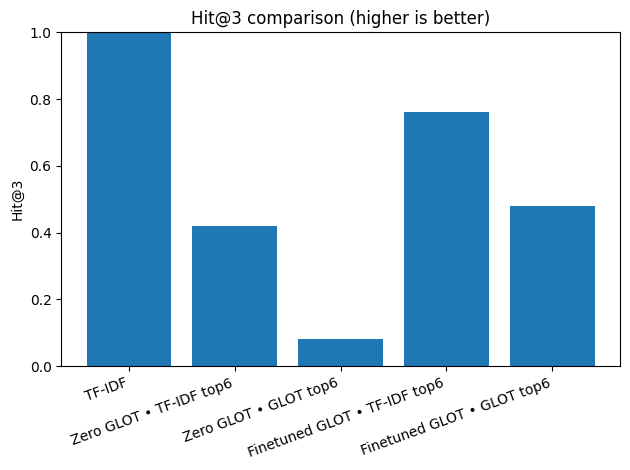

In [ ]:
plt.figure()
plt.title("Hit@3 comparison (higher is better)")
plt.bar(summary_df["model"], summary_df["Hit@3"])
plt.xticks(rotation=20, ha="right")
plt.ylim(0, 1)
plt.ylabel("Hit@3")
plt.tight_layout()
plt.show()

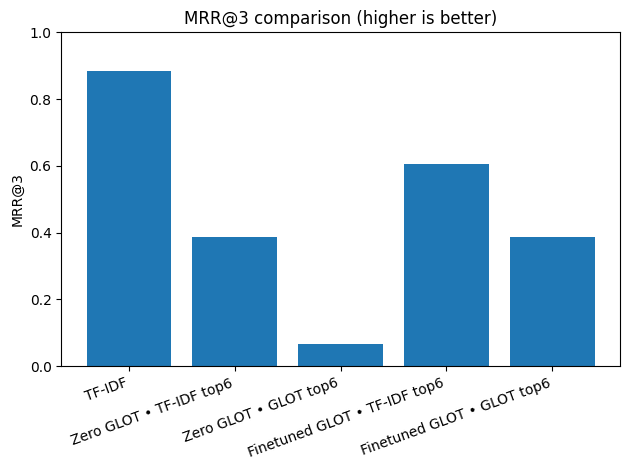

In [ ]:
plt.figure()
plt.title("MRR@3 comparison (higher is better)")
plt.bar(summary_df["model"], summary_df["MRR@3"])
plt.xticks(rotation=20, ha="right")
plt.ylim(0, 1)
plt.ylabel("MRR@3")
plt.tight_layout()
plt.show()

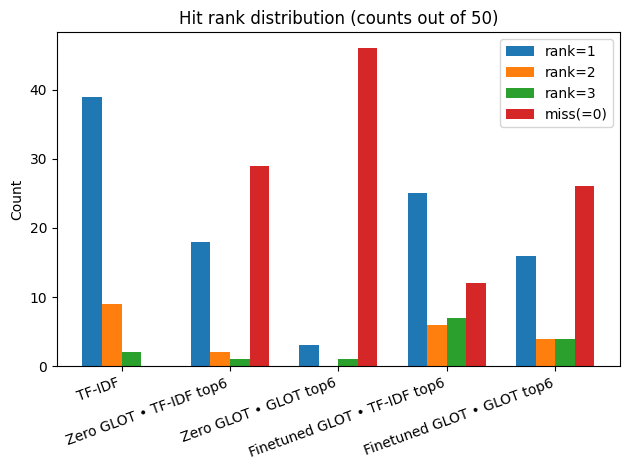

In [ ]:
rank_counts = summary_df[["model","rank1_cnt","rank2_cnt","rank3_cnt","rank0_cnt"]].set_index("model")
plt.figure()
plt.title("Hit rank distribution (counts out of 50)")
x = np.arange(len(rank_counts.index))
w = 0.18
plt.bar(x - 1.5*w, rank_counts["rank1_cnt"], width=w, label="rank=1")
plt.bar(x - 0.5*w, rank_counts["rank2_cnt"], width=w, label="rank=2")
plt.bar(x + 0.5*w, rank_counts["rank3_cnt"], width=w, label="rank=3")
plt.bar(x + 1.5*w, rank_counts["rank0_cnt"], width=w, label="miss(=0)")
plt.xticks(x, rank_counts.index, rotation=20, ha="right")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
out_path = Path("models_comparison_summary.xlsx")
with pd.ExcelWriter(out_path) as wr:
    summary_df.to_excel(wr, sheet_name="metrics_summary", index=False)
    oracle_info.to_excel(wr, sheet_name="oracle_scores_info", index=False)
    std_tfidf.to_excel(wr, sheet_name="std_tfidf", index=False)
    std_z_m2.to_excel(wr, sheet_name="std_zero_m2", index=False)
    std_z_m3.to_excel(wr, sheet_name="std_zero_m3", index=False)
    std_ft_m2.to_excel(wr, sheet_name="std_ft_m2", index=False)
    std_ft_m3.to_excel(wr, sheet_name="std_ft_m3", index=False)
    cmp_df.to_excel(wr, sheet_name="per_question_compare", index=False)

out_path

WindowsPath('models_comparison_summary.xlsx')

In [ ]:
BASE = Path(".")

if "df_tfidf" not in globals():
    df_tfidf = pd.read_excel(BASE / "tfidf_top3_evidence.xlsx")

if "z_m3" not in globals():
    xls = pd.ExcelFile(BASE / "glot500_eval.xlsx")
    sheet = "mode3_glot6" if "mode3_glot6" in xls.sheet_names else "mode3_glot6_maxsim"
    z_m3 = pd.read_excel(BASE / "glot500_eval.xlsx", sheet_name=sheet)

if "ft_m3" not in globals():
    xls = pd.ExcelFile(BASE / "glot500_finetuned_eval.xlsx")
    sheet = "mode3_glot6_ft" if "mode3_glot6_ft" in xls.sheet_names else "mode3_glot6_maxsim_ft"
    ft_m3 = pd.read_excel(BASE / "glot500_finetuned_eval.xlsx", sheet_name=sheet)

def stack_from_raw(df, pid_cols, score_cols, q_col="Question", g_col=None):
    if g_col is None:
        g_col = "Gold PID" if "Gold PID" in df.columns else "gold_pid"
    X, y = [], []
    for _, r in df.iterrows():
        gold = str(r[g_col]).strip()
        for pc, sc in zip(pid_cols, score_cols):
            pid = str(r.get(pc, "")).strip()
            scv = r.get(sc, np.nan)
            if pd.isna(scv):
                continue
            X.append(float(scv))
            y.append(1 if pid == gold else 0)
    return np.array(X, float), np.array(y, int)

print("Rehydrated:",
      f"df_tfidf={len(df_tfidf)}",
      f"z_m3={len(z_m3)}",
      f"ft_m3={len(ft_m3)}")

Rehydrated: df_tfidf=50 z_m3=50 ft_m3=50


In [ ]:
def normalize_text(s: str):
    s = str(s).strip().lower()
    # basic Persian/Arabic normalization
    s = s.replace("ي", "ی").replace("ك", "ک")
    s = re.sub(r"[^\w\s]+", " ", s, flags=re.UNICODE)
    s = re.sub(r"\s+", " ", s, flags=re.UNICODE)
    return s

def jaccard(a: str, b: str):
    A = set(normalize_text(a).split())
    B = set(normalize_text(b).split())
    if not A or not B:
        return 0.0
    return len(A & B) / len(A | B)

def build_overlap_df():
    rows = []
    # TF-IDF
    for _, r in df_tfidf.iterrows():
        q = r["Question"]
        ev = r.get("rank1 evidence", "")
        hit = 1 if str(r.get("Gold PID","")).strip() == str(r.get("rank1 PID","")).strip() else 0
        rows.append({"model":"TF-IDF","Question":q,"overlap":jaccard(q, ev),"hit1":hit})
    # Zero GLOT mode3
    for _, r in z_m3.iterrows():
        q = r["Question"]
        ev = r.get("seg1","")
        gold = str(r.get("Gold PID", r.get("gold_pid",""))).strip()
        pid1 = str(r.get("pid1","")).strip()
        hit = 1 if gold == pid1 else 0
        rows.append({"model":"Zero • GLOT top6","Question":q,"overlap":jaccard(q, ev),"hit1":hit})
    # FT GLOT mode3
    for _, r in ft_m3.iterrows():
        q = r["Question"]
        ev = r.get("seg1","")
        gold = str(r.get("Gold PID", r.get("gold_pid",""))).strip()
        pid1 = str(r.get("pid1","")).strip()
        hit = 1 if gold == pid1 else 0
        rows.append({"model":"FT • GLOT top6","Question":q,"overlap":jaccard(q, ev),"hit1":hit})
    return pd.DataFrame(rows)

ov = build_overlap_df()

In [ ]:
def bucket(x):
    if x <= 0.15: return "Low (≤0.15)"
    if x >= 0.35: return "High (≥0.35)"
    return "Mid"

ov["bucket"] = ov["overlap"].apply(bucket)

pivot = ov.pivot_table(index="bucket", columns="model", values="hit1", aggfunc="mean")
display(pivot)

model,FT • GLOT top6,TF-IDF,Zero • GLOT top6
bucket,,,
High (≥0.35),1.000000,0.818182,NaN
Low (≤0.15),0.282051,0.727273,0.045455
Mid,0.333333,0.785714,0.166667


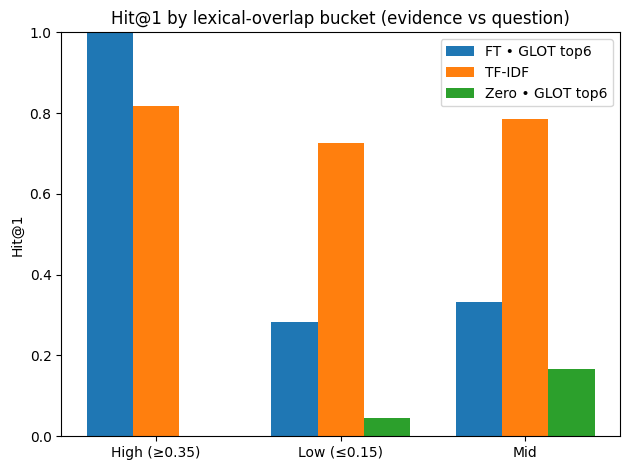

In [ ]:
plt.figure()
plt.title("Hit@1 by lexical-overlap bucket (evidence vs question)")
x = np.arange(len(pivot.index))
w = 0.25
models = pivot.columns.tolist()
for i, m in enumerate(models):
    plt.bar(x + (i - (len(models)-1)/2)*w, pivot[m].values, width=w, label=m)
plt.xticks(x, pivot.index)
plt.ylim(0,1); plt.ylabel("Hit@1")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# TF-IDF raw (for scores/evidence)
if "df_tfidf" not in globals():
    df_tfidf = pd.read_excel(BASE / "tfidf_top3_evidence.xlsx")

# Zero-shot GLOT • TF-IDF top-6 (sheet name may vary)
if "z_m2" not in globals():
    xls = pd.ExcelFile(BASE / "glot500_eval.xlsx")
    sheet = None
    for cand in ["mode2_tfidf", "mode2_tfidf_maxsim"]:
        if cand in xls.sheet_names:
            sheet = cand; break
    if sheet is None:
        raise KeyError(f"No mode2 sheet found in glot500_eval.xlsx. Have: {xls.sheet_names}")
    z_m2 = pd.read_excel(BASE / "glot500_eval.xlsx", sheet_name=sheet)

# Finetuned GLOT • TF-IDF top-6 (sheet name may vary)
if "ft_m2" not in globals():
    xls = pd.ExcelFile(BASE / "glot500_finetuned_eval.xlsx")
    sheet = None
    for cand in ["mode2_tfidf_ft", "mode2_tfidf_maxsim_ft"]:
        if cand in xls.sheet_names:
            sheet = cand; break
    if sheet is None:
        raise KeyError(f"No mode2 FT sheet found in glot500_finetuned_eval.xlsx. Have: {xls.sheet_names}")
    ft_m2 = pd.read_excel(BASE / "glot500_finetuned_eval.xlsx", sheet_name=sheet)

print("Rehydrated:",
      f"df_tfidf={len(df_tfidf)}",
      f"z_m2={len(z_m2)}",
      f"ft_m2={len(ft_m2)}")

Rehydrated: df_tfidf=50 z_m2=50 ft_m2=50


In [ ]:
def _gold_col(df):
    return "Gold PID" if "Gold PID" in df.columns else ("gold_pid" if "gold_pid" in df.columns else None)

def _rank_of_gold(pid_list, gold):
    for i, p in enumerate(pid_list, start=1):
        if p and str(p).strip() == str(gold).strip():
            return i
    return 0

def build_overlap_df_mode2(df_tfidf, z_m2, ft_m2):
    rows = []

    # TF-IDF (evidence: rank1 evidence)
    for _, r in df_tfidf.iterrows():
        q   = str(r["Question"])
        g   = str(r.get("Gold PID","")).strip()
        pids = [str(r.get(c,"")).strip() for c in ["rank1 PID","rank2 PID","rank3 PID"]]
        rk   = _rank_of_gold(pids, g)
        ev   = str(r.get("rank1 evidence",""))
        rows.append({
            "model": "TF-IDF",
            "Question": q,
            "overlap": jaccard(q, ev),
            "hit1": 1 if rk==1 else 0,
            "hit2": 1 if (rk and rk<=2) else 0,
            "hit3": 1 if (rk and rk<=3) else 0
        })

    # Zero GLOT (mode2_tfidf) (evidence: seg1)
    gz = _gold_col(z_m2)
    for _, r in z_m2.iterrows():
        q   = str(r["Question"])
        g   = str(r.get(gz,"")).strip()
        pids = [str(r.get(c,"")).strip() for c in ["pid1","pid2","pid3"]]
        rk   = _rank_of_gold(pids, g)
        ev   = str(r.get("seg1",""))
        rows.append({
            "model": "Zero • GLOT (TFIDF top6)",
            "Question": q,
            "overlap": jaccard(q, ev),
            "hit1": 1 if rk==1 else 0,
            "hit2": 1 if (rk and rk<=2) else 0,
            "hit3": 1 if (rk and rk<=3) else 0
        })

    # FT GLOT (mode2_tfidf_ft) (evidence: seg1)
    gf = _gold_col(ft_m2)
    for _, r in ft_m2.iterrows():
        q   = str(r["Question"])
        g   = str(r.get(gf,"")).strip()
        pids = [str(r.get(c,"")).strip() for c in ["pid1","pid2","pid3"]]
        rk   = _rank_of_gold(pids, g)
        ev   = str(r.get("seg1",""))
        rows.append({
            "model": "FT • GLOT (TFIDF top6)",
            "Question": q,
            "overlap": jaccard(q, ev),
            "hit1": 1 if rk==1 else 0,
            "hit2": 1 if (rk and rk<=2) else 0,
            "hit3": 1 if (rk and rk<=3) else 0
        })

    return pd.DataFrame(rows)

ov2 = build_overlap_df_mode2(df_tfidf, z_m2, ft_m2)

In [ ]:
ov2["bucket"] = ov2["overlap"].apply(bucket)

# Pivot tables
pv1 = ov2.pivot_table(index="bucket", columns="model", values="hit1", aggfunc="mean")
pv2 = ov2.pivot_table(index="bucket", columns="model", values="hit2", aggfunc="mean")
pv3 = ov2.pivot_table(index="bucket", columns="model", values="hit3", aggfunc="mean")

print("Hit@1 by overlap bucket (TF-IDF top-6 retrieval):")
display(pv1)
print("\nHit@2 by overlap bucket (TF-IDF top-6 retrieval):")
display(pv2)
print("\nHit@3 by overlap bucket (TF-IDF top-6 retrieval):")
display(pv3)

Hit@1 by overlap bucket (TF-IDF top-6 retrieval):


model,FT • GLOT (TFIDF top6),TF-IDF,Zero • GLOT (TFIDF top6)
bucket,,,
High (≥0.35),1.000000,0.818182,0.727273
Low (≤0.15),0.405405,0.727273,0.166667
Mid,0.571429,0.785714,0.400000



Hit@2 by overlap bucket (TF-IDF top-6 retrieval):


model,FT • GLOT (TFIDF top6),TF-IDF,Zero • GLOT (TFIDF top6)
bucket,,,
High (≥0.35),1.000000,0.909091,0.727273
Low (≤0.15),0.540541,1.000000,0.208333
Mid,0.714286,0.964286,0.466667



Hit@3 by overlap bucket (TF-IDF top-6 retrieval):


model,FT • GLOT (TFIDF top6),TF-IDF,Zero • GLOT (TFIDF top6)
bucket,,,
High (≥0.35),1.000000,1.0,0.727273
Low (≤0.15),0.675676,1.0,0.208333
Mid,1.000000,1.0,0.533333


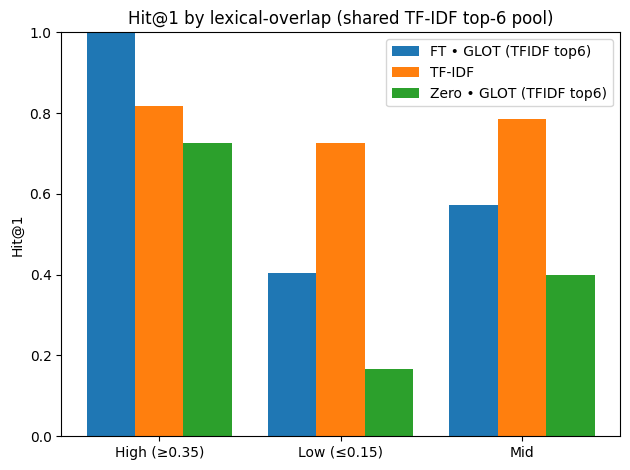

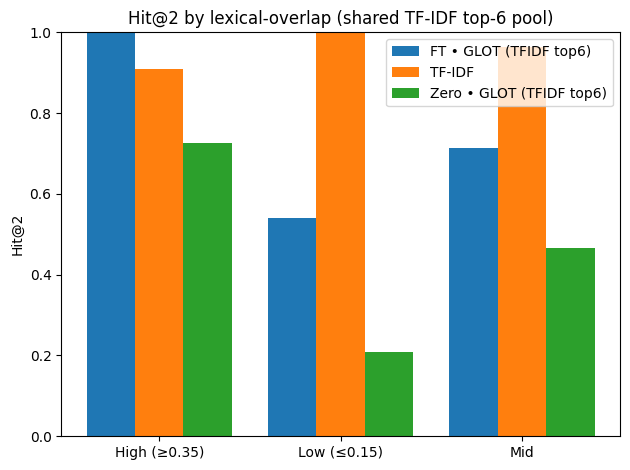

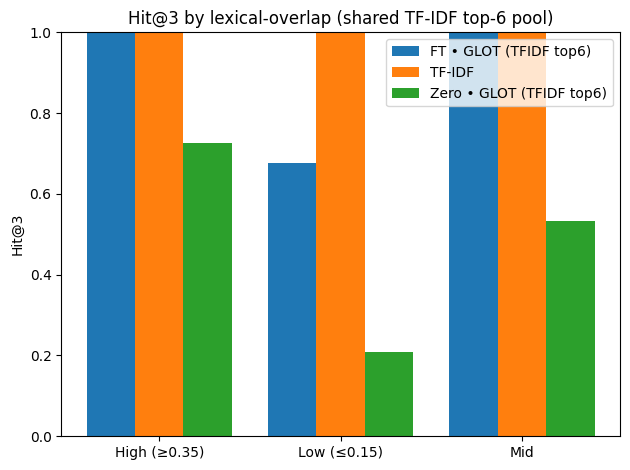

In [ ]:
def plot_bucket_bars(pivot, title, ylabel):
    plt.figure()
    plt.title(title)
    x = np.arange(len(pivot.index))
    models = pivot.columns.tolist()
    w = 0.8 / max(1, len(models))
    for i, m in enumerate(models):
        plt.bar(x + (i - (len(models)-1)/2)*w, pivot[m].values, width=w, label=m)
    plt.xticks(x, pivot.index)
    plt.ylim(0,1); plt.ylabel(ylabel)
    plt.legend(); plt.tight_layout(); plt.show()

plot_bucket_bars(pv1, "Hit@1 by lexical-overlap (shared TF-IDF top-6 pool)", "Hit@1")
plot_bucket_bars(pv2, "Hit@2 by lexical-overlap (shared TF-IDF top-6 pool)", "Hit@2")
plot_bucket_bars(pv3, "Hit@3 by lexical-overlap (shared TF-IDF top-6 pool)", "Hit@3")

In [ ]:
def gold_col(df):
    return "Gold PID" if "Gold PID" in df.columns else "gold_pid"

def extract_gold_rank_score(df, model_name, pid_cols, score_cols, q_col="Question"):
    gcol = gold_col(df)
    rows = []
    for _, r in df.iterrows():
        q = str(r[q_col])
        g = str(r.get(gcol, "")).strip()
        pids   = [str(r.get(c, "")).strip() for c in pid_cols]
        scores = [r.get(c, np.nan) for c in score_cols]
        rk, sc = 0, np.nan
        for i, (pid, s) in enumerate(zip(pids, scores), start=1):
            if pid and pid == g:
                rk, sc = i, (float(s) if pd.notna(s) else np.nan)
                break
        rows.append({"Question": q, "model": model_name, "gold_rank": rk, "gold_score": sc})
    return pd.DataFrame(rows)

In [ ]:
parts = []
parts.append(extract_gold_rank_score(
    df_tfidf, "TF-IDF",
    pid_cols=["rank1 PID","rank2 PID","rank3 PID"],
    score_cols=["rank1 score","rank2 score","rank3 score"],
))

parts.append(extract_gold_rank_score(
    z_m2, "Zero • GLOT (TFIDF top6)",
    pid_cols=["pid1","pid2","pid3"],
    score_cols=["rank1 score","rank2 score","rank3 score"],
))

parts.append(extract_gold_rank_score(
    ft_m2, "FT • GLOT (TFIDF top6)",
    pid_cols=["pid1","pid2","pid3"],
    score_cols=["rank1 score","rank2 score","rank3 score"],
))

parts.append(extract_gold_rank_score(
    z_m3, "Zero • GLOT (GLOT top6)",
    pid_cols=["pid1","pid2","pid3"],
    score_cols=["rank1 score","rank2 score","rank3 score"],
))

parts.append(extract_gold_rank_score(
    ft_m3, "FT • GLOT (GLOT top6)",
    pid_cols=["pid1","pid2","pid3"],
    score_cols=["rank1 score","rank2 score","rank3 score"],
))

perq = pd.concat(parts, ignore_index=True)

In [ ]:
rank_wide  = perq.pivot_table(index="Question", columns="model", values="gold_rank")
score_wide = perq.pivot_table(index="Question", columns="model", values="gold_score")

In [ ]:
out_path = BASE / "per_question_gold_rank_score.xlsx"
with pd.ExcelWriter(out_path) as wr:
    perq.to_excel(wr, sheet_name="long", index=False)
    rank_wide.reset_index().to_excel(wr, sheet_name="rank_wide", index=False)
    score_wide.reset_index().to_excel(wr, sheet_name="score_wide", index=False)

In [ ]:
try:
    from caas_jupyter_tools import display_dataframe_to_user as show_df
except ImportError:
    def show_df(name: str, df):
        from IPython.display import display
        print(f"[Table] {name}  →  {df.shape[0]} rows × {df.shape[1]} cols")
        display(df)

In [ ]:
show_df("Per-question gold rank (wide)", rank_wide.reset_index())

[Table] Per-question gold rank (wide)  →  50 rows × 6 cols


model,Question,FT • GLOT (GLOT top6),FT • GLOT (TFIDF top6),TF-IDF,Zero • GLOT (GLOT top6),Zero • GLOT (TFIDF top6)
0,کدام اتوی موی چرخشی بدون حرارت زیاد مو رو صاف ...,0.0,0.0,1.0,0.0,3.0
1,کدام ادو پرفیوم بوی بتادین دارد؟,0.0,0.0,1.0,0.0,0.0
2,کدام ادو پرفیوم مردانه مشابه برند اصلی است؟,0.0,0.0,1.0,1.0,0.0
3,کدام اسباب بازی شبیه عکسش نیست؟,0.0,0.0,2.0,0.0,0.0
4,کدام اسپری دوفاز بوی نامناسبی دارد؟,1.0,1.0,1.0,0.0,0.0
5,کدام بازی تکرار پذیری زیادی داره؟,0.0,2.0,3.0,0.0,0.0
6,کدام بازی فکری بازطراحی از بازی مسترجک پاکت هست؟,1.0,1.0,1.0,0.0,0.0
7,کدام بازی فکری مفرح و جذاب برای سنین مختلف است؟,0.0,2.0,1.0,0.0,1.0
8,کدام بخور سرد قابل اطمینان نیست؟,0.0,3.0,2.0,0.0,1.0
9,کدام تشک برای بیماری که نمیتواند حرکت کند مناس...,1.0,1.0,1.0,0.0,0.0


In [ ]:
FIG_W, FIG_H = 28, 7
XTICK_STEP   = 2
LW, MS       = 1.2, 4

In [ ]:
questions = rank_wide.index.tolist()
idx = np.arange(len(questions))
xticks_idx = np.arange(0, len(questions), XTICK_STEP)
xticks_lbl = [i+1 for i in xticks_idx]

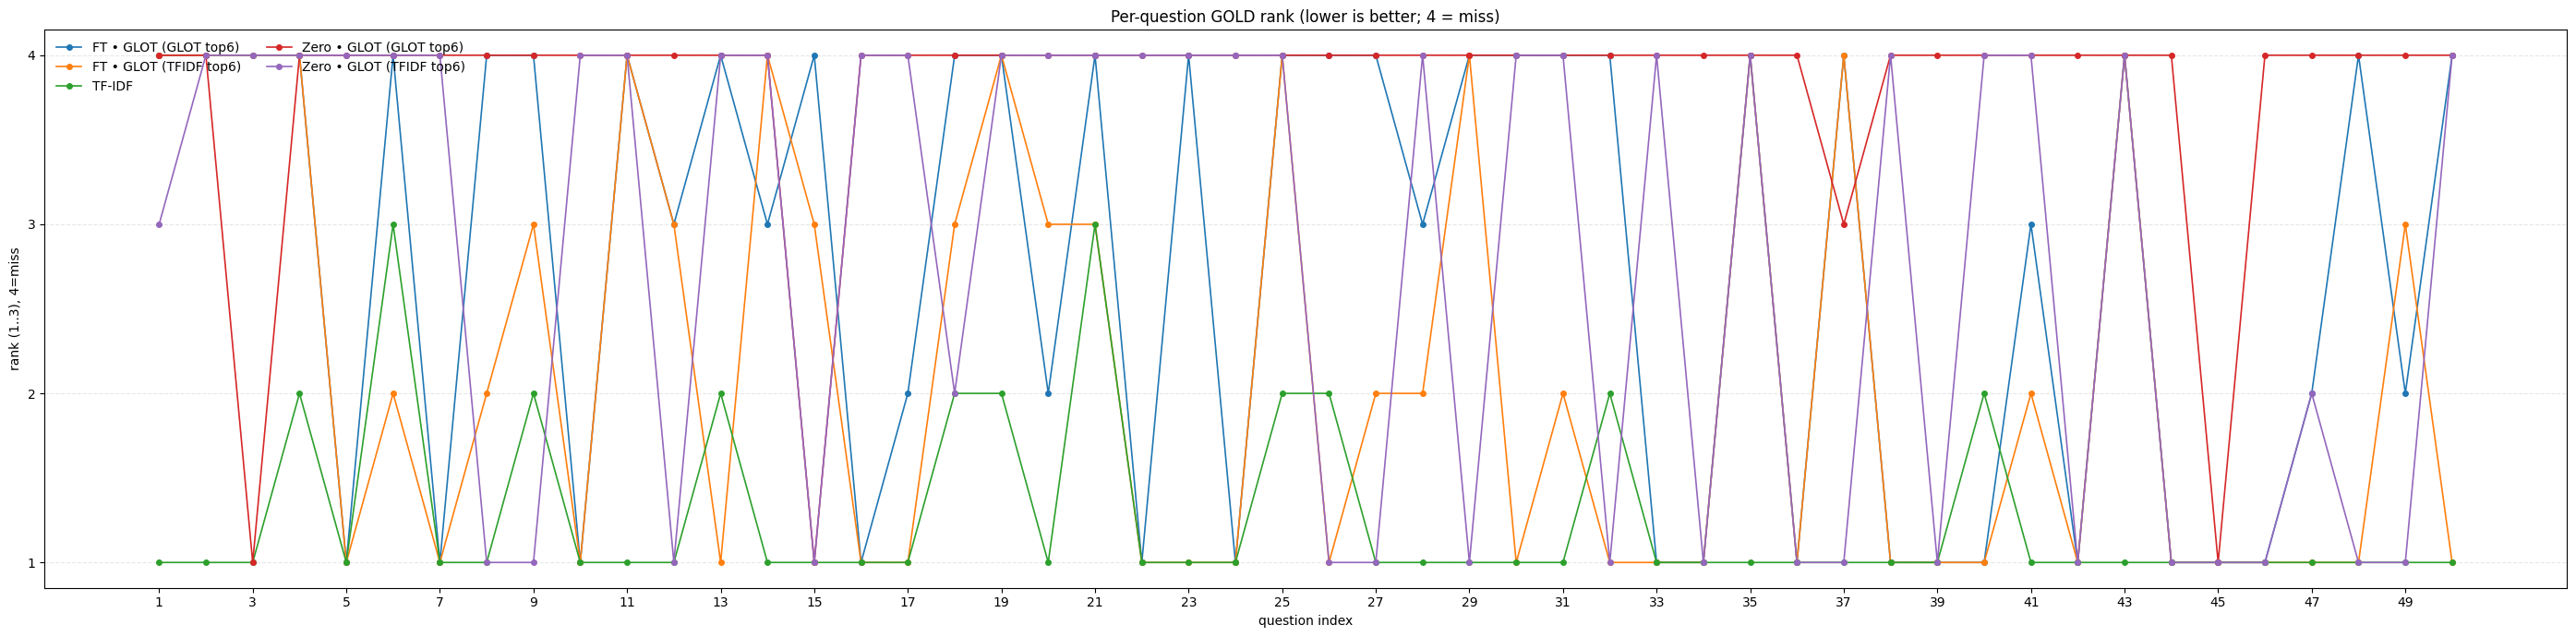

In [ ]:
# 1) Rank chart
rank_plot = rank_wide.copy().reindex(index=questions).replace(0, 4)

plt.figure(figsize=(FIG_W, FIG_H))
plt.title("Per-question GOLD rank (lower is better; 4 = miss)")
for col in rank_plot.columns:
    plt.plot(idx, rank_plot[col].values, marker='o', linewidth=LW, markersize=MS, label=col)
plt.xlabel("question index")
plt.ylabel("rank (1..3), 4=miss")
plt.xticks(xticks_idx, xticks_lbl, rotation=0)
plt.yticks([1,2,3,4])
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.legend(loc='upper left', ncol=2, frameon=False)
plt.tight_layout()
plt.savefig("gold_rank_per_question.png", dpi=200, bbox_inches="tight")
plt.show()

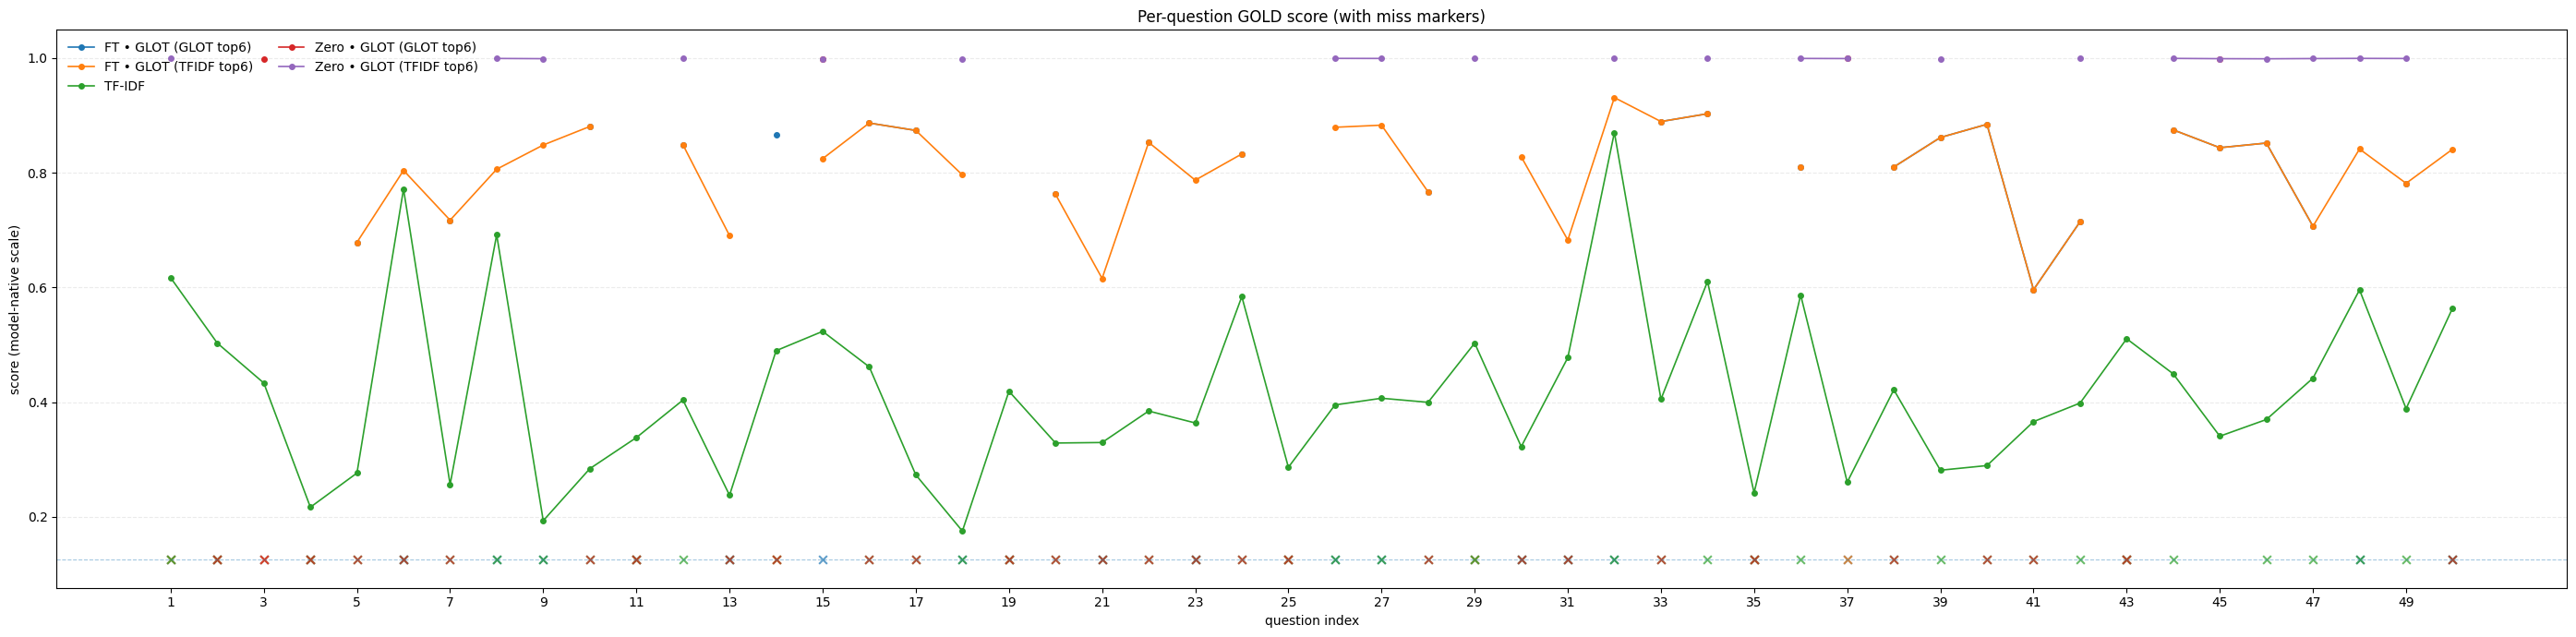

In [ ]:
# 2) Score chart
score_plot = score_wide.reindex(index=questions)

finite_vals = score_plot.values[np.isfinite(score_plot.values)]
y_min = float(np.min(finite_vals)) if finite_vals.size else 0.0
y_max = float(np.max(finite_vals)) if finite_vals.size else 1.0
pad   = 0.06 * (y_max - y_min if y_max > y_min else 1.0)
y_miss = y_min - pad

plt.figure(figsize=(FIG_W, FIG_H))
plt.title("Per-question GOLD score (with miss markers)")
for col in score_plot.columns:
    y = score_plot[col].values.astype(float)
    plt.plot(idx, y, marker='o', linewidth=LW, markersize=MS, label=col)
    miss_idx = np.where(~np.isfinite(y))[0]
    if len(miss_idx):
        plt.scatter(miss_idx, np.full(len(miss_idx), y_miss), marker='x', s=40, alpha=0.7)

plt.axhline(y=y_miss, linestyle='--', linewidth=0.8, alpha=0.4)
plt.xlabel("question index")
plt.ylabel("score (model-native scale)")
plt.xticks(xticks_idx, xticks_lbl)
plt.ylim(y_miss - pad, y_max + pad)
plt.grid(True, axis='y', linestyle='--', alpha=0.25)
plt.legend(loc='upper left', ncol=2, frameon=False)
plt.tight_layout()
plt.savefig("gold_score_per_question.png", dpi=200, bbox_inches="tight")
plt.show()

In [ ]:
print("Missing (NaN) counts per model in gold_score:")
print(score_wide.isna().sum().sort_values(ascending=False))

Missing (NaN) counts per model in gold_score:
model
Zero • GLOT (GLOT top6)     46
Zero • GLOT (TFIDF top6)    29
FT • GLOT (GLOT top6)       26
FT • GLOT (TFIDF top6)      12
TF-IDF                       0
dtype: int64


In [ ]:
# 2) Score chart (Without miss for covered points)

FIG_W, FIG_H = 28, 7
XTICK_STEP   = 2
MS, EW       = 5, 0.8
DODGE        = 0.18
YJ_SCALE_S   = 0.01
YJ_SCALE_R   = 0.06
RANK_MISS    = 4

models    = list(rank_wide.columns)
questions = list(rank_wide.index)
idx       = np.arange(len(questions))
xti       = np.arange(0, len(questions), XTICK_STEP)
xtl       = [i+1 for i in xti]

if len(models) == 1:
    offsets = [0.0]
else:
    offsets = np.linspace(-DODGE, DODGE, len(models))

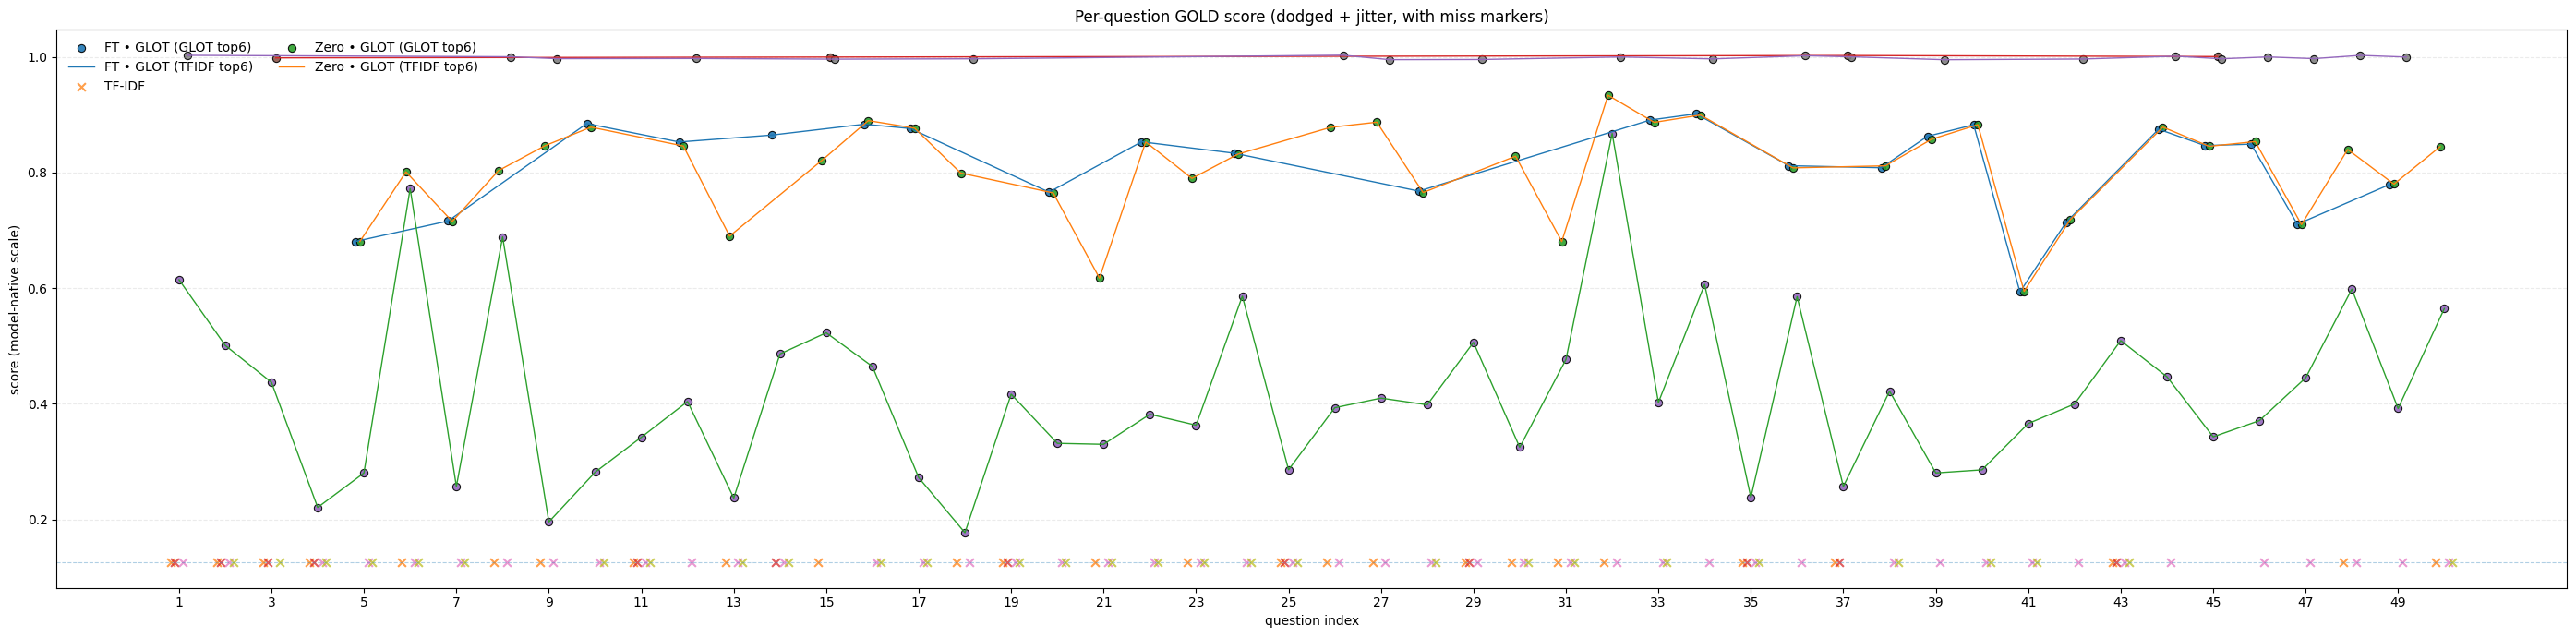

In [ ]:
score_plot = score_wide.reindex(index=questions).astype(float)

finite_vals = score_plot.values[np.isfinite(score_plot.values)]
ymin = float(np.min(finite_vals)) if finite_vals.size else 0.0
ymax = float(np.max(finite_vals)) if finite_vals.size else 1.0
yrng = (ymax - ymin) if ymax > ymin else 1.0
y_base_miss = ymin - 0.06*yrng

plt.figure(figsize=(FIG_W, FIG_H))
plt.title("Per-question GOLD score (dodged + jitter, with miss markers)")

for m_i, m in enumerate(models):
    y = score_plot[m].values.copy()
    rs = np.random.RandomState(200 + m_i)
    yj = (rs.rand(len(y)) - 0.5) * (YJ_SCALE_S * yrng)

    mask = np.isfinite(y)
    plt.scatter((idx + offsets[m_i])[mask], (y + yj)[mask],
                s=35, marker='o', linewidths=EW, edgecolors='black', alpha=0.9, label=m if m_i==0 else None)
    plt.plot((idx + offsets[m_i])[mask], (y + yj)[mask], linewidth=1.0)

    miss_idx = np.where(~mask)[0]
    if len(miss_idx):
        plt.scatter(miss_idx + offsets[m_i], np.full(len(miss_idx), y_base_miss),
                    marker='x', s=40, alpha=0.75)

plt.axhline(y=y_base_miss, linestyle='--', linewidth=0.8, alpha=0.35)
plt.xlabel("question index")
plt.ylabel("score (model-native scale)")
plt.xticks(xti, xtl)
plt.grid(True, axis='y', linestyle='--', alpha=0.25)
plt.legend(models, loc='upper left', ncol=2, frameon=False)
plt.tight_layout()
plt.savefig("gold_score_per_question_full_without_coverage.png", dpi=200, bbox_inches="tight")
plt.show()

# Bonus: Duplicate Detection

In [ ]:
import pandas as pd, numpy as np, itertools
from pathlib import Path
from sklearn.preprocessing import normalize

In [ ]:
CSV_PATH = Path("highest_3000_info_data_QA.csv")
df = pd.read_csv(CSV_PATH)

In [ ]:
df["product_id"] = df["product_id"].astype(str)
df["qa_pairs"]   = df["qa_pairs"].astype(str).fillna("")

In [ ]:
dup_mask = df.duplicated(subset=["product_id"], keep=False)
num_dup_rows = int(dup_mask.sum())
num_dup_pids = df.loc[dup_mask, "product_id"].nunique()
print(f"Duplicated rows (by product_id): {num_dup_rows}")
print(f"Duplicated product_ids: {num_dup_pids}")

Duplicated rows (by product_id): 1482
Duplicated product_ids: 663


In [ ]:
dup_df = df[dup_mask].copy()

In [ ]:
qa_vecs = embed_texts_ft(dup_df["qa_pairs"].tolist(), max_len=512, batch=16)
qa_vecs = normalize(qa_vecs)

In [ ]:
idx_map = {idx: i for i, idx in enumerate(dup_df.index)}

In [ ]:
pair_rows = []
per_pid_stats = []

In [ ]:
for pid, g in dup_df.groupby("product_id"):
    idxs = list(g.index)
    if len(idxs) < 2:
        continue

    V = qa_vecs[[idx_map[i] for i in idxs]]
    S = (V @ V.T)

    sims = []
    for i in range(len(idxs)):
        for j in range(i+1, len(idxs)):
            c = float(S[i, j])
            pair_rows.append({
                "product_id": pid,
                "row_i": int(idxs[i]),
                "row_j": int(idxs[j]),
                "cosine": round(c, 4),
            })
            sims.append(c)

    sims = np.array(sims, dtype=np.float32)
    per_pid_stats.append({
        "product_id": pid,
        "n_rows": len(idxs),
        "n_pairs": int(len(sims)),
        "mean": float(sims.mean()),
        "min": float(sims.min()),
        "max": float(sims.max()),
        "std": float(sims.std(ddof=0)),
    })

In [ ]:
pairs_df = pd.DataFrame(pair_rows).sort_values(["product_id","cosine"], ascending=[True,False])
stats_df = pd.DataFrame(per_pid_stats).sort_values("mean", ascending=False)

In [ ]:
if not pairs_df.empty:
    all_sims = pairs_df["cosine"].to_numpy()
    overall = {
        "num_dup_rows": num_dup_rows,
        "num_dup_product_ids": num_dup_pids,
        "num_pairs": int(len(all_sims)),
        "overall_mean": float(all_sims.mean()),
        "overall_min": float(all_sims.min()),
        "overall_max": float(all_sims.max()),
        "overall_std": float(all_sims.std(ddof=0)),
    }
else:
    overall = {
        "num_dup_rows": num_dup_rows,
        "num_dup_product_ids": num_dup_pids,
        "num_pairs": 0,
        "overall_mean": "",
        "overall_min": "",
        "overall_max": "",
        "overall_std": "",
    }

summary_df = pd.DataFrame([overall])

In [ ]:
with pd.ExcelWriter("qa_dup_similarity_report.xlsx") as wr:
    summary_df.to_excel(wr, sheet_name="summary", index=False)
    stats_df.to_excel(wr, sheet_name="per_product", index=False)
    pairs_df.to_excel(wr, sheet_name="pairs", index=False)

print("Saved → qa_dup_similarity_report.xlsx")

Saved → qa_dup_similarity_report.xlsx


In [ ]:
work_df = df.copy()
work_df["product_id"] = work_df["product_id"].astype(str)
work_df["qa_pairs"]   = work_df["qa_pairs"].astype(str).fillna("")
work_df = work_df[work_df["qa_pairs"] != ""].reset_index().rename(columns={"index":"orig_index"})

In [ ]:
V_all = embed_texts_ft(work_df["qa_pairs"].tolist(), max_len=512, batch=16)
V_all = normalize(V_all)

In [ ]:
target_n = len(pairs_df)
rng = np.random.default_rng(42)

seen = set()
neg_rows = []
N = len(work_df)

In [ ]:
while len(neg_rows) < target_n and len(seen) < 20 * target_n:
    i = int(rng.integers(0, N))
    j = int(rng.integers(0, N))
    if i == j:
        continue
    key = (i, j) if i < j else (j, i)
    if key in seen:
        continue
    seen.add(key)

    if work_df.loc[i, "product_id"] == work_df.loc[j, "product_id"]:
        continue

    cos = float(np.dot(V_all[i], V_all[j]))
    neg_rows.append({
        "row_i": int(work_df.loc[i, "orig_index"]),
        "row_j": int(work_df.loc[j, "orig_index"]),
        "product_i": work_df.loc[i, "product_id"],
        "product_j": work_df.loc[j, "product_id"],
        "cosine": round(cos, 4),
    })

In [ ]:
neg_df = pd.DataFrame(neg_rows)

In [ ]:
if not neg_df.empty:
    sims = neg_df["cosine"].to_numpy()
    random_summary = pd.DataFrame([{
        "num_random_pairs": int(len(neg_df)),
        "mean": float(sims.mean()),
        "min": float(sims.min()),
        "max": float(sims.max()),
        "std": float(sims.std(ddof=0)),
    }])
else:
    random_summary = pd.DataFrame([{
        "num_random_pairs": 0, "mean": "", "min": "", "max": "", "std": ""
    }])

In [ ]:
if not pairs_df.empty:
    dup_sims = pairs_df["cosine"].to_numpy()
    dup_overall = {
        "num_dup_pairs": int(len(dup_sims)),
        "mean": float(dup_sims.mean()),
        "min": float(dup_sims.min()),
        "max": float(dup_sims.max()),
        "std": float(dup_sims.std(ddof=0)),
    }
else:
    dup_overall = {"num_dup_pairs": 0, "mean": "", "min": "", "max": "", "std": ""}

compare_df = pd.DataFrame([
    {"bucket": "duplicates", **dup_overall},
    {"bucket": "random",     **{
        "num_dup_pairs": int(random_summary.loc[0, "num_random_pairs"]),
        "mean": random_summary.loc[0, "mean"],
        "min":  random_summary.loc[0, "min"],
        "max":  random_summary.loc[0, "max"],
        "std":  random_summary.loc[0, "std"],
    }},
])

In [ ]:
with pd.ExcelWriter("qa_dup_similarity_report.xlsx", mode="a", if_sheet_exists="replace") as wr:
    random_summary.to_excel(wr, sheet_name="random_summary", index=False)
    neg_df.to_excel(wr, sheet_name="random_pairs", index=False)
    compare_df.to_excel(wr, sheet_name="compare_overall", index=False)

print("Added 'random_summary', 'random_pairs', and 'compare_overall' to qa_dup_similarity_report.xlsx")

Added 'random_summary', 'random_pairs', and 'compare_overall' to qa_dup_similarity_report.xlsx


In [ ]:
THRESH = 0.77

In [ ]:
assert "cosine" in pairs_df.columns and "product_id" in pairs_df.columns
assert "cosine" in neg_df.columns and "product_i" in neg_df.columns and "product_j" in neg_df.columns

In [ ]:
dup_eval = pairs_df.copy()
dup_eval["detected"] = dup_eval["cosine"] >= THRESH

In [ ]:
neg_eval = neg_df.copy()
neg_eval["detected"] = neg_eval["cosine"] >= THRESH

In [ ]:
TP = int(dup_eval["detected"].sum())
FN = int((~dup_eval["detected"]).sum())
FP = int(neg_eval["detected"].sum())
TN = int((~neg_eval["detected"]).sum())

In [ ]:
prec = TP / (TP + FP) if (TP + FP) else 0.0
rec  = TP / (TP + FN) if (TP + FN) else 0.0
f1   = 2*prec*rec / (prec + rec) if (prec + rec) else 0.0
acc  = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) else 0.0
spec = TN / (TN + FP) if (TN + FP) else 0.0

In [ ]:
summary = pd.DataFrame([{
    "threshold": THRESH,
    "pairs_total_pos": int(len(dup_eval)),
    "pairs_total_neg": int(len(neg_eval)),
    "TP": TP, "FP": FP, "FN": FN, "TN": TN,
    "precision": round(prec, 4),
    "recall":    round(rec, 4),
    "f1":        round(f1, 4),
    "accuracy":  round(acc, 4),
    "specificity": round(spec, 4)
}])

In [ ]:
pid_cover = (
    dup_eval.groupby("product_id")["detected"]
    .any()
    .reset_index()
    .rename(columns={"detected": "covered"})
)
pid_covered = int(pid_cover["covered"].sum())
pid_total   = int(pid_cover.shape[0])
pid_cov_rate = pid_covered / pid_total if pid_total else 0.0

In [ ]:
coverage = pd.DataFrame([{
    "threshold": THRESH,
    "dup_product_ids_total": pid_total,
    "dup_product_ids_covered": pid_covered,
    "pid_coverage_rate": round(pid_cov_rate, 4)
}])

In [ ]:
def qa_text(i):
    try:
        return str(df.loc[i, "qa_pairs"])[:300]
    except Exception:
        return ""

In [ ]:
false_pos = neg_eval[neg_eval["detected"]].copy()
false_pos["qa_i"] = false_pos["row_i"].apply(qa_text)
false_pos["qa_j"] = false_pos["row_j"].apply(qa_text)
false_pos = false_pos.sort_values("cosine", ascending=False)

In [ ]:
false_neg = dup_eval[~dup_eval["detected"]].copy()
false_neg["qa_i"] = false_neg["row_i"].apply(qa_text)
false_neg["qa_j"] = false_neg["row_j"].apply(qa_text)
false_neg = false_neg.sort_values("cosine", ascending=True)

In [ ]:
with pd.ExcelWriter("qa_dup_similarity_report.xlsx", mode="a", if_sheet_exists="replace") as wr:
    summary.to_excel(wr, sheet_name=f"thresh_{THRESH:.2f}_summary", index=False)
    coverage.to_excel(wr, sheet_name=f"thresh_{THRESH:.2f}_pid_coverage", index=False)
    false_pos.to_excel(wr, sheet_name=f"thresh_{THRESH:.2f}_FP", index=False)
    false_neg.to_excel(wr, sheet_name=f"thresh_{THRESH:.2f}_FN", index=False)

print("Threshold evaluation written to qa_dup_similarity_report.xlsx")
print(summary.to_string(index=False))
print(coverage.to_string(index=False))

Threshold evaluation written to qa_dup_similarity_report.xlsx
 threshold  pairs_total_pos  pairs_total_neg   TP  FP  FN   TN  precision  recall     f1  accuracy  specificity
      0.77             1019             1019 1003   1  16 1018      0.999  0.9843 0.9916    0.9917        0.999
 threshold  dup_product_ids_total  dup_product_ids_covered  pid_coverage_rate
      0.77                    663                      655             0.9879
